# Présentation du projet : 

## Contexte 

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


## Données 



Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

## Mission
### Contraintes


* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

### Livrable attendu ici
Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherches associées (non cleané, pour comprendre votre démarche).

# Ressources : 

## Les données et leur description :

Site d'extraction des données :

Traitement de texte (NLP) : 
* Le cours OC sur le traitement de text : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/
* 
* 
* 
* Les ressources compémentaires proposées dans le projet :
    * La doc sklearn : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    * Article - overview extraction de mot-clé : https://jios.foi.hr/index.php/jios/article/view/938/724
    * Tuto Kaggle Word2Vec : https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words
    * Livre NLTK (Natural Language Toolkit) : http://www.nltk.org/book/
    * Slide de présentation séminaire sur "Topic Models" Thibaut THONET : https://www.irit.fr/IRIS-site/images/seminairs/Thonet2016.pdf

# Présentation du notebook : 

Ce notebook présente mon analyse exploratoire, 
<!-- qui se résume à d'une part l'exploration des tables, et d'autre part l'extraction des features pour notre modèle de ségmentation des clients. -->

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

# from sklearn import model_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import linear_model

# from sklearn.impute import KNNImputer
# from sklearn.decomposition import NMF
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import fowlkes_mallows_score
# from sklearn.metrics.pairwise import pairwise_kernels


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import LogisticRegression

# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.cluster.hierarchy import cut_tree

# Première lecture des données :

In [141]:
df1 = pd.read_csv(data_path + "QueryResults_Id_0_50000.csv")
df1 = df1.set_index("Id")#.iloc[:1000,:]
print(df1.shape)
df1.head(3)

(50000, 22)


PostTypeId  AcceptedAnswerId  ParentId         CreationDate  DeletionDate  \
Id                                                                              
4            1               7.0       NaN  2008-07-31 21:42:52           NaN   
6            1              31.0       NaN  2008-07-31 22:08:08           NaN   
7            2               NaN       4.0  2008-07-31 22:17:57           NaN   

    Score  ViewCount                                               Body  \
Id                                                                        
4     727    58688.0  <p>I want to use a <code>Track-Bar</code> to c...   
6     306    21663.0  <p>I have an absolutely positioned <code>div</...   
7     482        NaN  <p>An explicit cast to <code>double</code> lik...   

    OwnerUserId OwnerDisplayName  ...         LastEditDate  \
Id                                ...                        
4           8.0              NaN  ...  2021-02-26 03:31:15   
6           9.0              NaN  ...  2021-01-29 18:46:45   
7           9.0              NaN  ...  2019-10-21 14:03:54   

       LastActivityDate                                              Title  \
Id                                                                           
4   2021-02-26 03:31:15        How to convert a Decimal to a Double in C#?   
6   2021-01-29 18:46:45  Why did the width collapse in the percentage w...   
7   2019-10-21 14:03:54                                                NaN   

                                                 Tags AnswerCount  \
Id                                                                  
4   <c#><floating-point><type-conversion><double><...        14.0   
6                    <html><css><internet-explorer-7>         7.0   
7                                                 NaN         NaN   

   CommentCount  FavoriteCount  ClosedDate   CommunityOwnedDate ContentLicense  
Id                                                                              
4             5           55.0         NaN  2012-10-31 16:42:47   CC BY-SA 4.0  
6             0           12.0         NaN                  NaN   CC BY-SA 4.0  
7             0            NaN         NaN                  NaN   CC BY-SA 4.0  

[3 rows x 22 columns]

Visiblement seuls trois colonnes vont avoir un intérêt pour cette étude. Il s'agit des colonnes "Title" et "Body" comme ensemble d'entrée, et "Tags" comme sortie.

In [142]:
title = df1["Title"]
question = df1["Body"]
tags = df1["Tags"]

Il sera peut-être judicieux d'utiliser d'autres colonnes correspondant à la réponse de la communauté pour voir si le post a été tagué correctement. Il s'agirait de faire un  filtre sur les données d'apprentissage, puisqu'on ne veut pas apprendre des questions mal taguées. 

Pour le moment je vais me satisfaire de cet ensemble d'apprentissage. Comme c'est la première fois que je fais du NLP, je vais d'abord regarder comment faire un prétraitement sur les titres (parce que plus petit ensemble)

# 1 Preprocessing sur les tags 

Les tags sont dans un format entre balises, je vais les mettre dans une pd.DataFrame avec en colonne les différents tags et en ligne les posts. La matrice sera rempli du nombre d'occurence des tags. Elle sera donc sparse. 

In [150]:
tags = tags[~tags.isna()]
## test separation des tags entre balise
import re
print("test sur un post :", re.findall(r"\<([^>]*)",tags.iloc[0]))

## creation de la pd.DataFrame
df_tags = {}
for idx in tags.index : #[:1000] : 
    list_tags = re.findall(r"\<([^>]*)",tags.loc[idx])
    df_tags[idx] = pd.get_dummies(list_tags).sum()
df_tags = pd.DataFrame(df_tag).transpose()
df_tags = df_tags.fillna(0)
df_tags.head()

test sur un post : ['c#', 'floating-point', 'type-conversion', 'double', 'decimal']


.net  .net-2.0  .net-3.5   3d  64-bit  account  actionscript-3  \
4    0.0       0.0       0.0  0.0     0.0      0.0             0.0   
6    0.0       0.0       0.0  0.0     0.0      0.0             0.0   
9    1.0       0.0       0.0  0.0     0.0      0.0             0.0   
11   0.0       0.0       0.0  0.0     0.0      0.0             0.0   
13   0.0       0.0       0.0  0.0     0.0      0.0             0.0   

    active-directory  address-bar  adobe  ...  xampp  xdebug  xfdl  xml  \
4                0.0          0.0    0.0  ...    0.0     0.0   0.0  0.0   
6                0.0          0.0    0.0  ...    0.0     0.0   0.0  0.0   
9                0.0          0.0    0.0  ...    0.0     0.0   0.0  0.0   
11               0.0          0.0    0.0  ...    0.0     0.0   0.0  0.0   
13               0.0          0.0    0.0  ...    0.0     0.0   0.0  0.0   

    xml-comments  xsd  xslt  xss  youtube  zos  
4            0.0  0.0   0.0  0.0      0.0  0.0  
6            0.0  0.0   0.0  0.0      0.0  0.0  
9            0.0  0.0   0.0  0.0      0.0  0.0  
11           0.0  0.0   0.0  0.0      0.0  0.0  
13           0.0  0.0   0.0  0.0      0.0  0.0  

[5 rows x 402 columns]

Regardons comment sont répartis ces tags :

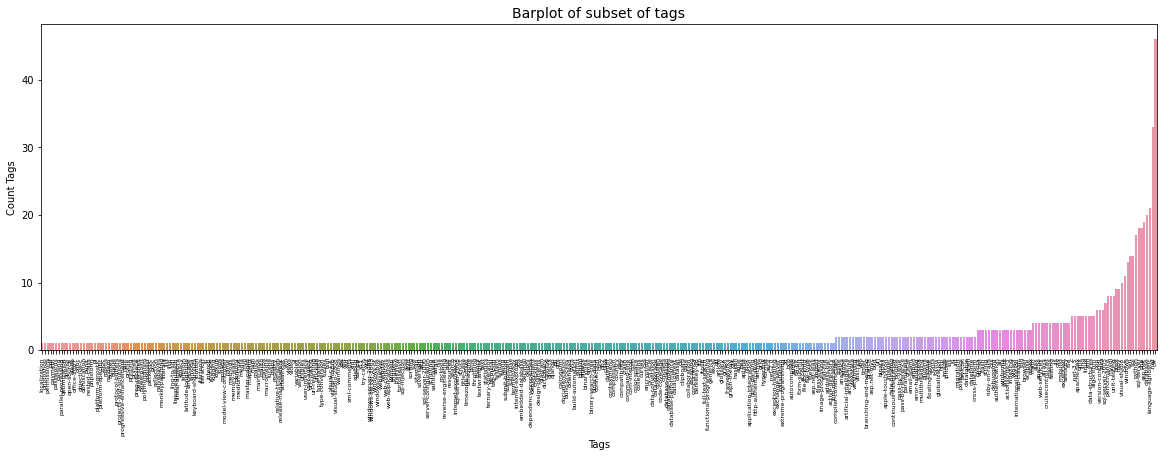

In [151]:
# df_tags.plot(kind="bar")
plt.rcParams["figure.figsize"] = (20,6)
tmp = df_tags.sum(axis=0).sort_values()
sns.barplot(y=tmp.values,x=tmp.index)
plt.xticks(rotation=90, fontsize=6)
plt.xlabel("Tags", fontsize=10)
plt.ylabel("Count Tags", fontsize=10)
plt.title("Barplot of subset of tags", fontsize=14)
plt.show()

Il serait intéressant de regrouper les tags similaires ##TODO

In [136]:
df_tags.columns

Index(['.net', '.net-2.0', '.net-3.5', '3d', '64-bit', 'account',
       'actionscript-3', 'active-directory', 'address-bar', 'adobe',
       ...
       'xampp', 'xdebug', 'xfdl', 'xml', 'xml-comments', 'xsd', 'xslt', 'xss',
       'youtube', 'zos'],
      dtype='object', length=402)

 Comment rendre plus facile l'apprentisage de ces 402 tags ? Faire un clustering sur les tags, apprendre ces groupes de tags puis les tags dans chaque groupe ?

# 2 Preprocessing sur les titres/corpus


## 2.1 En suivant le cours d'OC 
J'ai choisi de commencer par suivre les étapes [du cours d'OpenClassRoom sur les traitement textes](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles). 

### Récupération et exploration du corpus de texte 
Je ne suis pas concernée par la partie "scrap" puisque j'ai déjà mon texte. 

Néansmoins, il y a deux points nécessaires à traiter a ce stade : 
1. Il faut sortir de la syntaxe html pour avoir un format text. Les balises de code semblent importante à garder, ne serait-ce que parce que certaines contiennent le langage de programmation.
2. je vais essayer d'insérer les titles dans les corpus, car il y a {{title.isna().sum()/title.shape[0]*100}}$\%$ de valeurs maquantes pour les titles. 

#### De HTML à text

In [160]:
question.iloc[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

In [163]:
import os
import re
from boilerpy3 import extractors

# Condenses all repeating newline characters into one single newline character
def condense_newline(text):
    return '\n'.join([p for p in re.split('\n|\r', text) if len(p) > 0])

# Returns the text from a HTML file
def parse_html(html_path):
    # Text extraction with boilerpy3
    html_extractor = extractors.ArticleExtractor()
    return condense_newline(html_extractor.get_content_from_file(html_path))

# Extracts the text from all html files in a specified directory
def html_to_text(folder):
    parsed_texts = []
    filepaths = os.listdir(folder)

    for filepath in filepaths:
        filepath_full = os.path.join(folder, filepath)
        if filepath_full.endswith(".html"):
            parsed_texts.append(parse_html(filepath_full))
    return parsed_texts

# Your directory to the folder with scraped websites
scraped_dir = './scraped_pages'
parsed_texts = html_to_text(scraped_dir)

FileNotFoundError: [Errno 2] No such file or directory: './scraped_pages'

In [166]:
html_extractor = extractors.ArticleExtractor()
html_extractor.get_content(question)

TypeError: expected string or bytes-like object

In [164]:
help(extractors.ArticleExtractor())

Help on ArticleExtractor in module boilerpy3.extractors object:

class ArticleExtractor(Extractor)
 |  ArticleExtractor(raise_on_failure: bool = True) -> None
 |  
 |  A full-text extractor which is tuned towards news articles. In this scenario it achieves higher accuracy than
 |  DefaultExtractor. Works very well for most types of Article-like HTML.
 |  
 |  Method resolution order:
 |      ArticleExtractor
 |      Extractor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, raise_on_failure: bool = True) -> None
 |      Initialize extractor
 |      
 |      :param raise_on_failure: whether or not to raise an exception if a text extraction failure is encountered.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Extractor:
 |  
 |  get_content(self, text: str) -> str
 |  
 |  get_content_from_file(self, filename: str) -> str
 |  
 |  get_content_from_url(self, url: str) -> str
 |  
 |  get_doc(self, t

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
tmp = count_vect.fit_transform(tags)
tmp

<35x101 sparse matrix of type '<class 'numpy.int64'>'
	with 147 stored elements in Compressed Sparse Row format>

In [71]:
tags.iloc[0]

'<c#><floating-point><type-conversion><double><decimal>'

In [61]:
import nltk

# tmp = str.split(tags.iloc[0],">")
# tmp
# str.split(tmp,"<")
nltk.word_tokenize(tags)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/clairegayral/nltk_data'
    - '/home/clairegayral/.env_python/openclassroom/nltk_data'
    - '/home/clairegayral/.env_python/openclassroom/share/nltk_data'
    - '/home/clairegayral/.env_python/openclassroom/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [22]:
for k,v in db.items():
    print(v)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Il y a donc au total {{customers.shape[0]}} commandes, passées par  {{len(customers["customer_unique_id"].value_counts())}} clients différents. Cette table donne également 3 informations sur la localisation du client (zip code, city, state), contenues dans des variables catégorielles.

Petite vérification : Est-ce que les "customer_unique_id" ont bien tous une adresse unique ? 

In [5]:
unique_id = customers.iloc[:,1:]#["customer_unique_id"]
unique_id = unique_id.drop_duplicates(ignore_index = False)
unique_id = unique_id["customer_unique_id"]
customer_id_non_unique = unique_id.value_counts()>1
customer_id_non_unique = unique_id.value_counts()[customer_id_non_unique]
customer_id_non_unique = customer_id_non_unique.index
customer_id_non_unique = unique_id.isin(customer_id_non_unique)
customer_id_non_unique = unique_id[customer_id_non_unique].index
customers_non_unique_commande = customers.loc[customer_id_non_unique]
customers_non_unique_commande.sort_values(by="customer_unique_id").head(10)

customer_id                customer_unique_id  \
87012  d95f60d70d9ea9a7fe37c53c931940bb  004b45ec5c64187465168251cd1c9c2f   
72451  49cf243e0d353cd418ca77868e24a670  004b45ec5c64187465168251cd1c9c2f   
61403  f530197ea86ced9488a03d055e118ebf  0058f300f57d7b93c477a131a59b36c3   
36269  8ac44e9c15d396b8c3c7cbab0fff4536  0058f300f57d7b93c477a131a59b36c3   
54038  e024c1515b1062b1e7e613f840c35ba3  012452d40dafae4df401bced74cdb490   
45307  f8e05a045de09e7855c9df3bb8815e0e  012452d40dafae4df401bced74cdb490   
91727  483468a56a54dbbbf8f2b2354cc8a729  0178b244a5c281fb2ade54038dd4b161   
57218  ea6ba2b2e27f7efea73bdeab7fd6e4a0  0178b244a5c281fb2ade54038dd4b161   
82312  026ca919d538ee454a6d43fc8bd01de0  018b5a7502c30eb5f230f1b4eb23a156   
64800  b98e0d5aca458a26a6ff30fee0416ca2  018b5a7502c30eb5f230f1b4eb23a156   

       customer_zip_code_prefix         customer_city customer_state  
87012                     57035                maceio             AL  
72451                     57055                maceio             AL  
61403                     40731              salvador             BA  
36269                     41370              salvador             BA  
54038                      3984             sao paulo             SP  
45307                      3220             sao paulo             SP  
91727                     12518         guaratingueta             SP  
57218                     14960        novo horizonte             SP  
82312                     74936  aparecida de goiania             GO  
64800                     74976  aparecida de goiania             GO

Visiblement non ! Je pense qu'il sera donc préférable d'utiliser la table ```geolocation``` pour accéder à ces information. Vérifions si cette table est plus propre : 

In [6]:
print("\t Value counts of city for zip code = 71065: \n",
    geolocation.loc[geolocation["geolocation_zip_code_prefix"] == 71065,
                    "geolocation_city"].value_counts())
print("\n\t Firsts 5 value counts of zip codes for city = maceio: \n",
      geolocation.loc[geolocation["geolocation_city"] == "maceio",
                      "geolocation_zip_code_prefix"].value_counts()[:5])

print("\n\t geolocation dataframe head :")
geolocation.head(2)

	 Value counts of city for zip code = 71065: 
 brasilia    75
brasília    10
guara        6
Name: geolocation_city, dtype: int64

	 Firsts 5 value counts of zip codes for city = maceio: 
 57035    400
57036    123
57052     99
57025     75
57010     74
Name: geolocation_zip_code_prefix, dtype: int64

	 geolocation dataframe head :


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP

Eh bien non ! Il va y avoir à faire un prétraitemement sur ces variables catégorielles. Il me semble que plusieurs options sont possibles :
* nettoyer les villes, donc nettoyage de texte, comme enlever les accents, les espaces en trop, les majuscules ...
* nettoyer les codes postaux : rassembler par ville ? 
* faire appel à la table ```geolocation``` pour utiliser les coordonnées géographiques des clients (latitude et longitude). 

Dans une première intention, je propose de n'utiliser que les codes postaux (zip code) comme proxy pour la localisation, ou même utiliser l'état de résidence (customer state). 

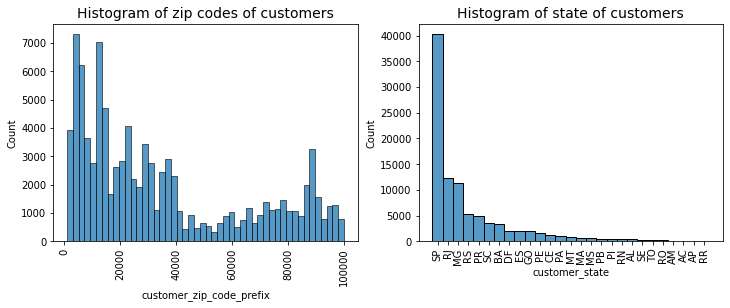

In [7]:
plt.figure(figsize=(12,4))
## removing duplicate customers (keep the 1st) :
tmp = customers.drop_duplicates(subset="customer_unique_id")

plt.subplot(1,2,1)
sns.histplot(tmp["customer_zip_code_prefix"])
plt.xticks(rotation=90)
plt.title("Histogram of zip codes of customers",
          fontsize=14)

## sort by customer state values counts : 
dummy = tmp["customer_state"].value_counts().index
dummy = pd.Series(dummy, name = 'customer_state').to_frame()
tmp = pd.merge( tmp, dummy, on = "customer_state", how = 'right')

plt.subplot(1,2,2)
sns.histplot(tmp["customer_state"])
plt.xticks(rotation=90)
plt.title("Histogram of state of customers", 
         fontsize=14)
plt.show()

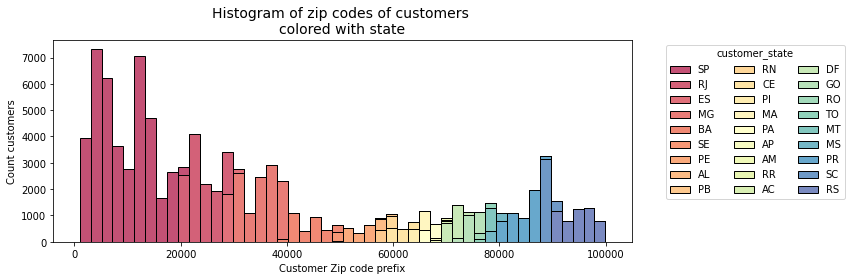

In [8]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

tmp = customers.drop_duplicates(subset="customer_unique_id")
tmp = tmp.sort_values("customer_zip_code_prefix")
n_state = len(np.unique(tmp["customer_state"])) 
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=tmp, x="customer_zip_code_prefix", hue="customer_state",  
             multiple="stack", palette=sns.color_palette("Spectral",n_colors=n_state),
             legend=True, ax=ax )
move_legend(ax, "upper left", **{"bbox_to_anchor":(1.05, 1), "ncol" :3})
plt.title("Histogram of zip codes of customers \ncolored with state",
          fontsize=14)
plt.xlabel("Customer Zip code prefix")
plt.ylabel("Count customers")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"customer_location.jpg")
plt.show()

Une très grande majorité de clients sont dans l'état "SP" : a voir s'il on ne biaise pas les données en ne gardant que l'état. Les zip codes ont l'air répartis beaucoup plus homogènement, et me semblent donc à priori plus appropriés.

La table "consumers" ne contient donc que des information géographiques, qui ne me permettront pas de faire grand chose. Il va falloir regarder les autres tables. J'extrait tout de même cette information de zipcode pour la suite, dans une table de travail à l'échelle du client : 

In [9]:
tmp = customers.drop_duplicates(subset="customer_unique_id")

my_customers = tmp[["customer_unique_id","customer_zip_code_prefix"]]
my_customers.head()

customer_unique_id  customer_zip_code_prefix
0  861eff4711a542e4b93843c6dd7febb0                     14409
1  290c77bc529b7ac935b93aa66c333dc3                      9790
2  060e732b5b29e8181a18229c7b0b2b5e                      1151
3  259dac757896d24d7702b9acbbff3f3c                      8775
4  345ecd01c38d18a9036ed96c73b8d066                     13056

## 1.2 Recency, Frequency, Monetary Value  (RFM) :

Suite aux conseil de mon mentor, j'ai fait une partie de feature engineering, avec la méthode RFM, dont voilà quelques ressources à ce sujet : 
* https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp
* https://www.kaggle.com/amangiri/rmf-analysis
* https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232
* https://www.definitions-marketing.com/definition/segmentation-rfm/

A noter : j'ai fait cette partie à posteriori, après avoir exploré les différentes tables c'est comme ça que je savais comment le faire facilement.

### 1.2.1 Recency :
La première variable que je vais créer est une variable correspondant au temps qu'il s'est écoulé depuis le dernier achat. Cette variable va être à actualiser régulièrement, c'est d'ailleurs ce qui risque d'être l'actualisation à évaluer (car si l'on n'apprend pas cette variable régulièrement, l'apprentissage sera vite biaisé). Il se trouve que les variables temporelles sont dans la table "orders", explorée après. 

In [10]:
tmp = pd.merge(customers[["customer_id","customer_unique_id"]], 
               orders[["customer_id", "order_id","order_purchase_timestamp"]], 
               on="customer_id", how="right")
## get the lastest order date of each customer 
customer_last_timestamp = tmp[["customer_unique_id",
           "order_purchase_timestamp"]].groupby("customer_unique_id").max()
## use datetime format
customer_last_timestamp = pd.to_datetime(customer_last_timestamp["order_purchase_timestamp"],
                     format = "%Y-%m-%d %H:%M:%S")
## substrack the date of the latest command in the data : 
t_max = customer_last_timestamp.max()
recency = pd.Series(t_max-customer_last_timestamp, name = "recency")
## get the difference in decimal days format : 
recency =  recency / np.timedelta64(1, "D")
recency = recency.reset_index()

my_customers = pd.merge(my_customers, recency, on="customer_unique_id", how="left")

### 1.2.2 Frequency : 
Pour avoir la fréquence de commande du client, je vais utiliser juste le nombre de commande par consommateur sur l'ensemble du dataset que j'ai. Il pourrait être pertinent de le prendre à partir du certaine date, à voir avec Olist ce qu'ils en pensent. 

In [11]:
frequency = tmp.customer_unique_id.value_counts()
frequency = pd.Series(frequency).reset_index()
frequency = frequency.rename(columns={"index":"customer_unique_id",
                                      "customer_unique_id":"frequency"})
my_customers = pd.merge(my_customers, frequency, on="customer_unique_id", how="left")

### 1.2.3 Monetary Value : 
Enfin, il est question d'extraire le prix du total des commandes passées par le consommateur : il faut donc que je somme les prix de fret et de commande, pour toutes les commandes, par utilisateur. J'ai décidé d'utiliser la table "order_payment", et de faire une jointure avec mon tmp (qui contient "order_id" et "customer_unique_id".)

In [12]:
tmp = pd.merge(tmp, order_payments[["order_id","payment_value"]], 
               on="order_id", how="left")
monetary_value = tmp.groupby("customer_unique_id").sum()
monetary_value = monetary_value.reset_index()
monetary_value = monetary_value.rename(columns={"payment_value":"monetary_value"})
my_customers = pd.merge(my_customers, monetary_value, on="customer_unique_id", how="left")

In [13]:
my_customers.head()

customer_unique_id  customer_zip_code_prefix     recency  \
0  861eff4711a542e4b93843c6dd7febb0                     14409  519.100498   
1  290c77bc529b7ac935b93aa66c333dc3                      9790  277.862431   
2  060e732b5b29e8181a18229c7b0b2b5e                      1151  151.057326   
3  259dac757896d24d7702b9acbbff3f3c                      8775  218.058102   
4  345ecd01c38d18a9036ed96c73b8d066                     13056   80.318611   

   frequency  monetary_value  
0          1          146.87  
1          1          335.48  
2          1          157.73  
3          1          173.30  
4          1          252.25

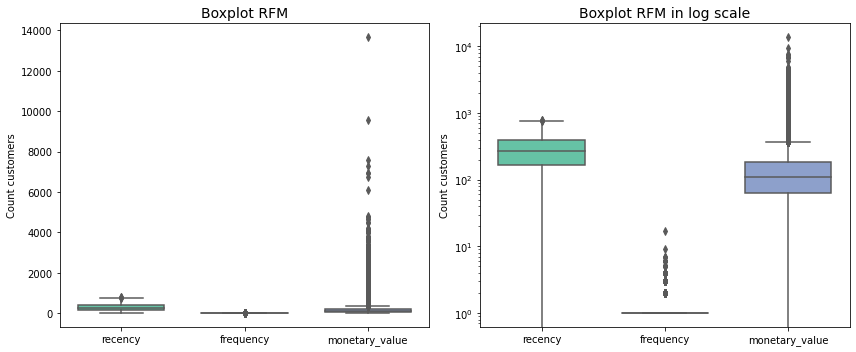

In [14]:
attributes = ["recency", "frequency", "monetary_value"]
rfm = my_customers[attributes]

# plt.rcParams['figure.figsize'] = [12,5]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,
            whis=1.5,saturation=1, width=0.7)
plt.title("Boxplot RFM", fontsize = 14)
plt.ylabel("Count customers")
# plt.savefig(res_path+"figures/"+"boxplot_RFM.jpg")

plt.subplot(1,2,2)
plt.yscale("log")
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,
            whis=1.5,saturation=1, width=0.7)
plt.title("Boxplot RFM in log scale", fontsize = 14)
plt.ylabel("Count customers")
plt.savefig(res_path+"figures/"+"order_boxplot_RFM.jpg")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Count customers')

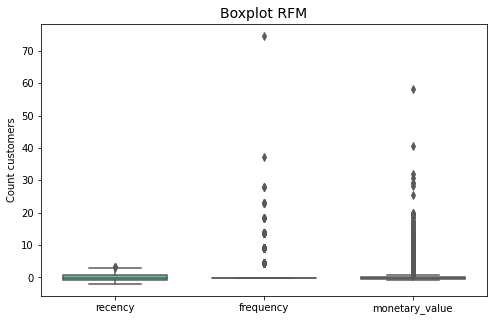

In [15]:
my_std = StandardScaler(with_mean=True)
my_std.fit(rfm)
rfm_std = my_std.transform(rfm)
rfm_std = pd.DataFrame(rfm_std, columns=rfm.columns, index=rfm.index)
plt.figure(figsize=(8,5))
sns.boxplot(data = rfm_std, orient="v", palette="Set2" ,
            whis=1.5,saturation=1, width=0.7)
plt.title("Boxplot RFM", fontsize = 14)
plt.ylabel("Count customers")
# plt.savefig(res_path+"figures/"+"boxplot_RFM.jpg")


# 2. A l'échelle des commandes

## 2.1 Caractéristiques des commandes (orders)
Ensuite, nous cherchons à classifier les clients selon leur consommation : regardons donc l'échelle "commande".

In [16]:
print("shape : ", orders.shape)
print("number of NaNs :",orders.isna().sum().sum(),"\n")
print(orders.order_status.value_counts())
orders.head(3)

shape :  (99441, 8)
number of NaNs : 4908 

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00

Cette table regroupe les informations de status de la commande : la date et l'heure à laquelle elle a été passée, validée, expédiée, reçue. Elle contient aussi une variable de status qui me semble particulièrement intéressante. Je vectorise cette variable catégorielle dans ma table de sortie :


In [17]:
my_orders = orders[['order_id', 'customer_id']].copy()
y = orders[['order_id','order_status']]
y = y.set_index("order_id")
y = y.astype("category")

## to compute one hot encoder, finally keep categorical for the moment
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(y)
# y_dummies = pd.DataFrame(enc.transform(y).toarray(),
#                           index = y.index, columns=np.unique(y))
# y_dummies = y_dummies.add_prefix("order_status_").reset_index()
# y_dummies = y_dummies.astype("category")
# my_orders = pd.merge(my_orders, y_dummies, on="order_id", how="left")

my_orders = pd.merge(my_orders, y, on="order_id", how="left")

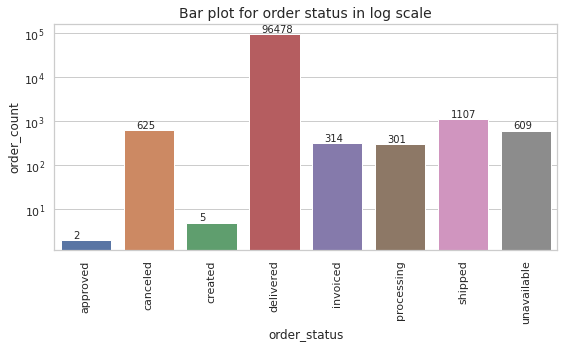

In [18]:
count_status = my_orders["order_status"].value_counts()
count_status = count_status.reset_index()
count_status = count_status.rename(columns={"index":"order_status", 
                                    "order_status":"order_count"})
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,5))
plt.yscale("log")
ax = sns.barplot(x="order_status", y = "order_count", data = count_status)
# calculate the percentages and annotate the sns barplot
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 4,
            rect.get_height()*1.1,
            "%.0f"% rect.get_height(), fontsize=10)

plt.xticks(rotation=90)

ax.set_title("Bar plot for order status in log scale", fontsize=14)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"order_status.jpg")
plt.show()


Pour les variables temporelles, je propose d'extraire plusieurs méta-variables :
* la date de commande seule
* l'heure de commande seule  
* la différence entre la date de livraison estimée et la date de livraison déclarée par le client (en jours)
* la différence entre la date de livraison déclarée par le client et la date de livraison déclarée par l'entreprise d'acheminement (en jours)

In [19]:
purchase_timestamp = pd.Series(pd.to_datetime(orders.order_purchase_timestamp,
                     format = "%Y-%m-%d %H:%M:%S"), dtype="object",
                               index = orders.order_id, name = "order_purchase_date")
orders.shape

(99441, 8)

In [20]:
order_dates = pd.DataFrame(index=orders.order_id)

## Let's begin with purchase date and time split : 
purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp,
                     format = "%Y-%m-%d %H:%M:%S")

purchase_date = pd.to_datetime(purchase_timestamp.dt.date, 
                               format = "%Y-%m-%d")
order_dates.at[:,"order_purchase_date"] = purchase_date.values

purch_time = purchase_timestamp.dt.time 
order_dates.at[:,"order_purchase_time"] = purch_time.values

order_dates = order_dates.astype({"order_purchase_date":"object",
                                  "order_purchase_time":"object"})

In [21]:
## Then, use delta time for delivery date comparison
estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date,
                             format = "%Y-%m-%d %H:%M:%S")
delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date,
                             format = "%Y-%m-%d %H:%M:%S") 
delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date,
                             format = "%Y-%m-%d %H:%M:%S") 

delta_estimated_declared = estimated_delivery_date - delivered_customer_date
delta_estimated_declared = delta_estimated_declared / np.timedelta64(1, "D")
order_dates.at[:,"order_dt_estimated_declared"] = delta_estimated_declared.values

delta_decalared_customer_carrier = delivered_customer_date - delivered_carrier_date
delta_decalared_customer_carrier = delta_decalared_customer_carrier / np.timedelta64(1, "D")
order_dates.at[:,"order_dt_decalared_customer_carrier"] = delta_decalared_customer_carrier.values


In [22]:
## save in a working pd.DataFrame : 
my_orders = pd.merge(my_orders, order_dates, on="order_id",how="left")
my_orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status  order_purchase_date order_purchase_time  \
0    delivered  2017-10-02 00:00:00            10:56:33   
1    delivered  2018-07-24 00:00:00            20:41:37   
2    delivered  2018-08-08 00:00:00            08:38:49   

   order_dt_estimated_declared  order_dt_decalared_customer_carrier  
0                     7.107488                             6.062650  
1                     5.355729                            12.039410  
2                    17.245498                             9.178113

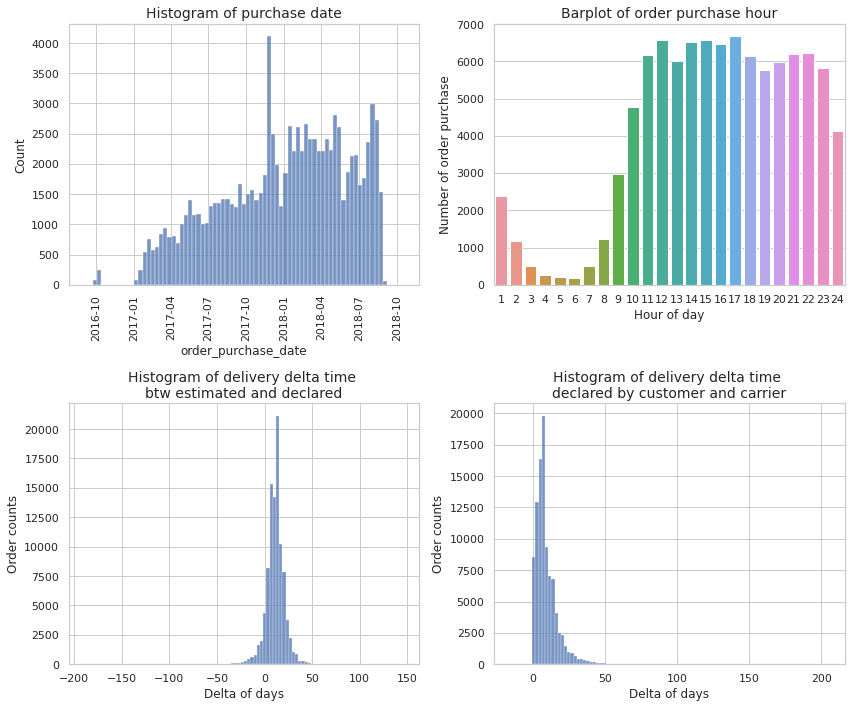

In [23]:
## Check with graphics :

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(my_orders.order_purchase_date)
plt.xticks(rotation=90)
plt.title("Histogram of purchase date", fontsize=14)

plt.subplot(2,2,2)
tmp = pd.to_datetime(my_orders.order_purchase_time,  
                     format="%H:%M:%S")
tmp.groupby(tmp.dt.hour).count()
sns.barplot(x=np.arange(1,25), 
            y=tmp.groupby(tmp.dt.hour).count())
plt.title("Barplot of order purchase hour", fontsize=14)
plt.xlabel("Hour of day")
plt.ylabel("Number of order purchase")

plt.subplot(2,2,3)
sns.histplot(my_orders.order_dt_estimated_declared, bins=100)
plt.title("Histogram of delivery delta time \n"+
          "btw estimated and declared", fontsize=14)
plt.xlabel("Delta of days")
plt.ylabel("Order counts")

plt.subplot(2,2,4)
sns.histplot(my_orders.order_dt_decalared_customer_carrier, bins=100)
plt.title("Histogram of delivery delta time \n"+
          "declared by customer and carrier", fontsize=14)
plt.xlabel("Delta of days")
plt.ylabel("Order counts")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"order_time.jpg")
plt.show()


## TODO : Description des graphes 

## 2.2 Table des produits commandés (order_items)

Passons maintenant à l'étude de la table des produits commandés : 

In [24]:
print("shape : ", order_items.shape)
print("number of NaNs :",order_items.isna().sum().sum(),"\n")

order_items.head(3)

shape :  (112650, 7)
number of NaNs : 0 



order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
2  2018-01-18 14:48:30  199.0          17.87

Cette table contient la liste des produits commandés dans différentes commandes, avec leur prix et la date limite d'envoi. La colonne "order_item_id" correspond au numéro attribué à l'article dans la commande. Est-ce que les mêmes articles sont vendus à des prix différents sur cette plateforme de vente ?

In [25]:
duplicates = order_items[order_items.duplicated(subset = "product_id", keep = False)]
duplicates = duplicates.sort_values("product_id")
duplicates.drop_duplicates(["product_id", "price"])
print("shape of duplicates after removes those with same price and name:",duplicates.shape)
duplicates.drop_duplicates(["product_id"])
print("shape of duplicates after removes those with same name :",duplicates.shape)

shape of duplicates after removes those with same price and name: (94533, 7)
shape of duplicates after removes those with same name : (94533, 7)


Il semblerait que oui. A quoi ressemble la répartition des prix ? 

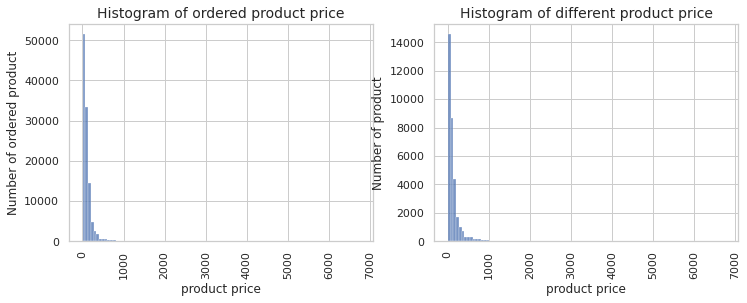

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(order_items.price, bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of ordered product price", fontsize=14)
plt.xlabel("product price")
plt.ylabel("Number of ordered product")

plt.subplot(1,2,2)
sns.histplot(order_items.drop_duplicates(subset="product_id").price, bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of different product price", fontsize=14)
plt.xlabel("product price")
plt.ylabel("Number of product")
plt.show()

On ne voit pas grand chose : passons en échelle log.

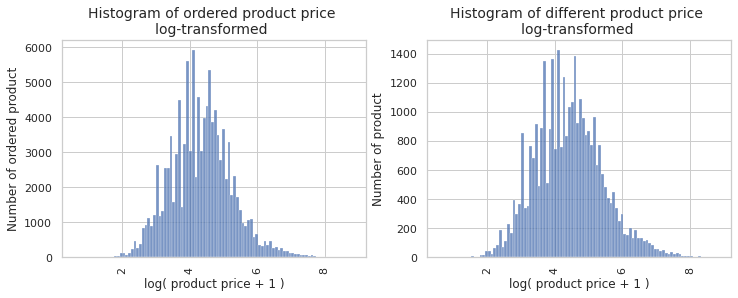

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(np.log(order_items.price+1), bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of ordered product price \nlog-transformed ",
         fontsize=14)
plt.xlabel("log( product price + 1 )")
plt.ylabel("Number of ordered product")

plt.subplot(1,2,2)
sns.histplot(np.log(order_items.drop_duplicates("product_id").price
                    +1), bins = 100)
plt.xticks(rotation=90)
plt.title("Histogram of different product price \nlog-transformed ", 
          fontsize=14)
plt.xlabel("log( product price + 1 )")
plt.ylabel("Number of product")
plt.show()

Les commandes avec plusieurs items n'ont pas l'air de contenir des items moins cher. Regardons la répartition du prix total de chaque commande, ainsi que le fret associé :  

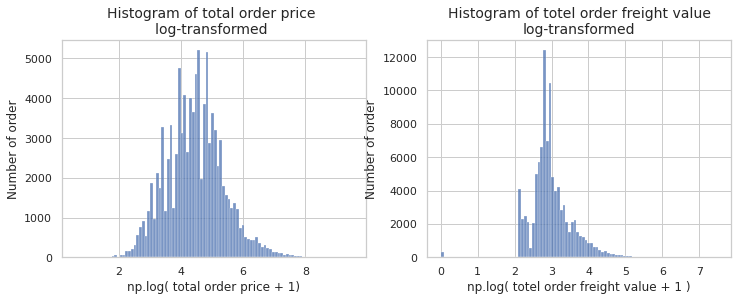

In [28]:
tmp = order_items.groupby("order_id").sum()
order_total_prices = pd.DataFrame(tmp.values, 
                                  columns = tmp.columns)
order_total_prices.at[:,"order_id"] = tmp.index

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(np.log( order_total_prices.price + 1 ), bins = 100)
plt.title("Histogram of total order price \nlog-transformed ", 
          fontsize=14)
plt.xlabel("np.log( total order price + 1)")
plt.ylabel("Number of order")

plt.subplot(1,2,2)
sns.histplot(np.log(order_total_prices.freight_value + 1 ), bins = 100)
plt.title("Histogram of totel order freight value\nlog-transformed", 
          fontsize=14)
plt.xlabel("np.log( totel order freight value + 1 )")
plt.ylabel("Number of order")
plt.show()

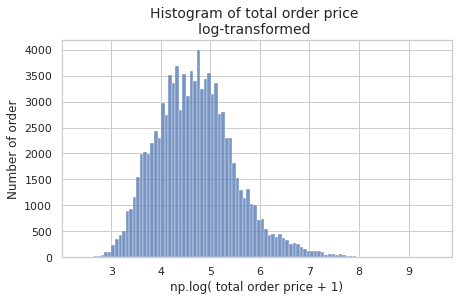

In [29]:
order_total_prices.at[:,"total"] = order_total_prices[["price","freight_value"]].sum(axis=1)

plt.figure(figsize=(7,4))
sns.histplot(np.log( order_total_prices.total + 1 ), bins = 100)
plt.title("Histogram of total order price \nlog-transformed ", 
          fontsize=14)
plt.xlabel("np.log( total order price + 1)")
plt.ylabel("Number of order")

plt.show()

Il n'y a rien d'inattendu : le prix des paniers en log-tranform a l'air répartis selon une loi normale. Pour le log du fret, on distingue 3 pics : un en 0, un en 2.3 et le troisième en 3.

In [30]:
my_orders = pd.merge(my_orders, order_total_prices[["order_id","price","freight_value"]], 
                     on="order_id", how="left")

## 2.3 Table des paiments (order_payments)

In [31]:
print("shape : ", order_payments.shape)
print("number of NaNs :",order_payments.isna().sum().sum(),"\n")

order_payments.head(3)

shape :  (103886, 5)
number of NaNs : 0 



order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71

Les 4 colonnes de cette table semblent pertinentes. Il y a trois variables correspondant au moyen de paiement (type de paiement, nombre d'échéance de paiement choisis, et nombre de type de paiement), et la dernière variable est le prix payé (à comparer avec la variable "price", calculée en faisant la somme des prix de la table "order_items")

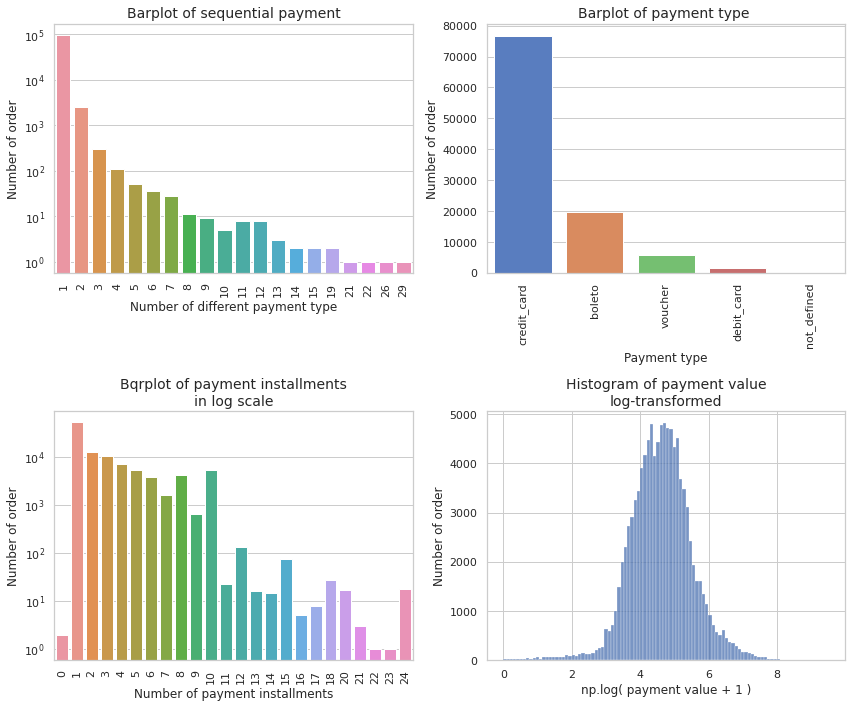

In [32]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
#### get nb of different payment type 
tmp = order_payments[["order_id","payment_sequential"]]
tmp = tmp.groupby("order_id").max()
tmp = tmp.value_counts().reset_index()
tmp = tmp.rename(columns={"payment_sequential":"order_count",
                                  0: "payment_sequential"})
sns.barplot(x="order_count",y="payment_sequential", data=tmp)
plt.title("Barplot of sequential payment", fontsize=14)
plt.xlabel("Number of different payment type")
plt.ylabel("Number of order")
plt.yscale("log")
plt.xticks(rotation=90)


plt.subplot(2,2,2)
tmp = order_payments.payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values, palette="muted")
plt.title("Barplot of payment type ", fontsize=14)
plt.xlabel("Payment type")
plt.ylabel("Number of order")
plt.xticks(rotation=90)


plt.subplot(2,2,3)
tmp = order_payments.payment_installments.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Bqrplot of payment installments\n"+
          "in log scale", fontsize=14)
plt.xlabel("Number of payment installments")
plt.ylabel("Number of order")
plt.yscale("log")
plt.xticks(rotation=90)

plt.subplot(2,2,4)
sns.histplot(np.log(order_payments.payment_value + 1 ), bins = 100)
plt.title("Histogram of payment value\nlog-transformed", 
          fontsize=14)
plt.xlabel("np.log( payment value + 1 )")
plt.ylabel("Number of order")

plt.tight_layout()
plt.savefig(res_path+"figures/"+"order_payment.jpg")
plt.show()

Let us now just compare the order_payments.payment_value with the order_total_prices.total

In [33]:
sum_payments_order = order_payments[["order_id",
                "payment_value"]].groupby("order_id").sum().reset_index()
tmp = pd.merge(sum_payments_order,
         order_total_prices[["order_id","total"]], on="order_id")
index_diff_non_null = np.where(abs(tmp[["payment_value",
                            "total"]].diff(axis = 1))>10**-2)[0]
print(len(index_diff_non_null),"anomalies")
tmp.iloc[index_diff_non_null].head(3)

387 anomalies


order_id  payment_value   total
165  00789ce015e7e5791c7914f32bb4fad4         190.81  168.83
525  016726239765c18f66826453f39c64e3         265.77  235.13
724  01e51b7c3025655646143d09b911e1d7          35.02   33.10

C'est assez étrange que les tables ne matchent pas. Il faudra faire attention à cela/demander au client si cela est normal. 

Ajoutons donc à la table d'exploitation ce qu'il semble pertinent d'extraire de cette table de paiements : 
* le nombre d'échelon de paiement 
* le type de paiement utilisé pour la majorité des payments (en terme de prix, "payment_type"). J'ai aussi regardé en terme de nombre de paiement, et en terme du plus gros paiment, les variables semblent presque identiques. 
* le nombre de type de paiement pour la commande

In [34]:
## payment_installments :
tmp = order_payments.sort_values("payment_installments",ascending=False).drop_duplicates("order_id","first")
my_orders = pd.merge(my_orders, tmp[["order_id","payment_installments"]], 
                     on="order_id", how="left")

In [35]:
# ## most frequent payment type :
# tmp = order_payments[["order_id", "payment_type"]].sort_values(by = "order_id")#"payment_type")
# tmp = pd.DataFrame(tmp.value_counts().reset_index())
# tmp = tmp.drop_duplicates("order_id")[["order_id", "payment_type"]]
# my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

In [36]:
# ## higher payment type :
# tmp = order_payments.sort_values("payment_value",
#                   ascending=False).drop_duplicates("order_id","first")
# tmp = tmp.rename(columns={"payment_type":"higher_payment_type"})
# my_orders = pd.merge(my_orders, tmp[["order_id","higher_payment_type"]], 
#                     on="order_id", how="left")

In [37]:
## most of payment type (max sum of value): 
## extract sum of payment value for each payment type : 
sub_table = order_payments[["order_id","payment_value","payment_type"]]
sub_table = sub_table.sort_values("order_id")
index = sub_table.drop_duplicates(["order_id","payment_type"]).index

tmp = sub_table.groupby(["order_id","payment_type"]).sum()
tmp = tmp.reset_index().set_index(index)

## drop duplicates where smaller payment_values (sum)
tmp = tmp.sort_values("payment_value", ascending=False)
tmp = tmp.drop_duplicates("order_id", keep="first")
payment_type = tmp.copy()

## idem : si je veux vectoriser la variable catégorielle "payment_type"
# ## vectorization of categorical var
y = tmp[['order_id','payment_type']]
y = y.astype({"payment_type":"category"}) 

# y = y.set_index("order_id")
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(y)
# y_dummies = pd.DataFrame(enc.transform(y).toarray(),
#                           index = y.index, columns=np.unique(y))
# y_dummies = y_dummies.add_prefix("paiement_type_").reset_index()
# y_dummies = y_dummies.astype("category")
# my_orders = pd.merge(my_orders, y_dummies, on="order_id", how="left")

my_orders = pd.merge(my_orders, y, on="order_id", how="left")


In [38]:
## number of payment type : 
tmp = order_payments[["order_id","payment_type"]].drop_duplicates()
tmp = tmp["order_id"].value_counts().reset_index()
tmp = tmp.rename(columns={"index":"order_id", 
                          "order_id":"nb_payment_type"})

my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

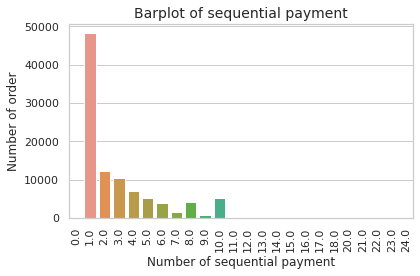

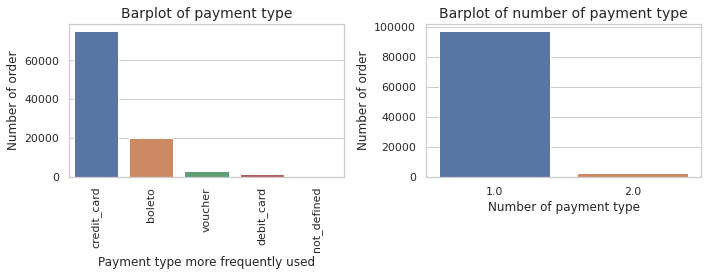

In [39]:
## graphics : 
plt.figure(figsize=(6,4))

tmp = my_orders.payment_installments.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Barplot of sequential payment",fontsize=14)
plt.xlabel("Number of sequential payment")
plt.ylabel("Number of order")
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(res_path+"figures/"+"order_payment_sequential.jpg")
plt.show()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
tmp = payment_type.payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.xticks(rotation=90)
plt.title("Barplot of payment type", fontsize=14)
plt.xlabel("Payment type more frequently used")
plt.ylabel("Number of order")

plt.subplot(1,2,2)
tmp = my_orders.nb_payment_type.value_counts()
sns.barplot(x=tmp.index,y=tmp.values)
plt.title("Barplot of number of payment type",fontsize=14)
plt.xlabel("Number of payment type")
plt.ylabel("Number of order")

plt.tight_layout()

plt.savefig(res_path+"figures/"+"order_payment_type.jpg")
plt.show()

## 2.4 Table des retours clients (order_reviews)

In [40]:
print("shape : ", order_reviews.shape)
print("number of NaNs :",order_reviews.isna().sum().sum(),"\n")

order_reviews.head(3)

shape :  (100000, 7)
number of NaNs : 146532 



review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   
2             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13  
2  2018-02-17 00:00:00     2018-02-18 14:36:24

Il y a un très grand nombre de valeurs manquantes : 

In [41]:
order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Ces valeurs manquantes sont dans les parties textuelles des commentaires (title et message). La deuxième chose marquante dans cette table est la dimension. Est ce qu'une même commande a des scores différents ? 

In [42]:
## number of different score for one order : 
tmp = order_reviews[["order_id","review_score"]].drop_duplicates()
tmp = tmp["order_id"].value_counts()
print("there are ", sum(tmp>1), "orders with different scores")

tmp = order_reviews[["order_id","review_score"]]
tmp = tmp.value_counts()
tmp = pd.Series(tmp.groupby("order_id").count(),
                   name="count_change_scores")
tmp = tmp.reset_index()
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

there are  209 orders with different scores


In [43]:
## mean score for one order : 
tmp = order_reviews.groupby("order_id").mean().reset_index()
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

In [44]:
## add count_reviews, count_messages, count_title, for one order : 
tmp = order_reviews.groupby("order_id").count().reset_index()
tmp = tmp[["order_id","review_id", "review_comment_title", "review_comment_message"]]

dict_rename = {"review_id":"count_review"}
for colname in tmp.columns[2:] :
    new_colname = "count"
    for str1 in colname.split("_")[1:] : 
        new_colname = str(new_colname+"_"+str1)
    dict_rename[colname]=new_colname
## also work : 
#     new_colname = [str("count_"+str1) for str1 in colname.split("_")[1:]]
#     dict_rename[colname]=new_colname
tmp = tmp.rename(columns=dict_rename)
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

Possible amélioration : 
* regarder dans les messages de review pourquoi les clients sont satisfaits/non satisfaits
* prendre en compte la temporalité des commentaires

In [45]:
my_orders.dtypes

order_id                                 object
customer_id                              object
order_status                           category
order_purchase_date                      object
order_purchase_time                      object
order_dt_estimated_declared             float64
order_dt_decalared_customer_carrier     float64
price                                   float64
freight_value                           float64
payment_installments                    float64
payment_type                           category
nb_payment_type                         float64
count_change_scores                       int64
review_score                            float64
count_review                              int64
count_comment_title                       int64
count_comment_message                     int64
dtype: object

# 3 A l'échelle des produits

Il va y avoir un certain travail à faire sur les produits, car c'est une échelle plus petite (plusieurs produits par commande) et il va falloir résumer les informations de cette très grande table pour en faire quelques colonnes dans la table my_orders.

## 3.1 La table des produits : 

In [46]:
print("shape : ", products.shape)
print("number of NaNs :",products.isna().sum().sum(),"\n")

# print(products.isna().sum())
products.head(3)

shape :  (32951, 9)
number of NaNs : 2448 



product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                 artes   
2  96bd76ec8810374ed1b65e291975717f         esporte_lazer   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0

Je propose d'utiliser une NMF sur les produits, afin de chercher à les regrouper en des sens sémantiques, et utiliser ce réduction de dimension pour qualifier les paniers : est ce que les produits achetés sont des hauts de gamme ? est ce qu'il s'agit de biens de consommation ? La constitution du panier est-il homogène ou hétérogène ? 

Pour choisir les paramètre de réduction de dimension qui correspondent le mieux à l'utilisation, je propose de l'utiliser pour prédire la catégorie du produit. 

In [47]:
## extract numeric table with id as index
X = products.copy()

X = X.set_index("product_id")
y = X["product_category_name"]
## soit fillna soit drop les produits
y = y.fillna("missing")
# missing_index = y[y.isna()].index
# y = y.drop(index=missing_index)
# X = X.drop(index=missing_index)
X = X.loc[:,~(X.dtypes == object)]
y = y.astype("category")

n_clusters = len(np.unique(y))
X.shape

(32951, 7)

Pour utiliser les pipelines de sklearn, j'ai besoin de n'avoir aucune valeur manquante. Je vais donc imputer les valeurs manquantes numériques par un algorithme des plus proches voisins, les valeurs manquantes catégorielles sont remplacées par une nouvelle catégorie 'missing'.

MSE = 363.840 (+/-5.289) for {'n_neighbors': 1}
MSE = 312.258 (+/-2.723) for {'n_neighbors': 2}
MSE = 293.258 (+/-2.890) for {'n_neighbors': 3}
MSE = 284.657 (+/-4.534) for {'n_neighbors': 4}
MSE = 278.012 (+/-3.873) for {'n_neighbors': 5}
MSE = 273.478 (+/-3.539) for {'n_neighbors': 6}
MSE = 270.014 (+/-3.446) for {'n_neighbors': 7}
MSE = 267.433 (+/-3.007) for {'n_neighbors': 8}
MSE = 265.345 (+/-2.872) for {'n_neighbors': 9}
MSE = 263.750 (+/-2.756) for {'n_neighbors': 10}
MSE = 262.441 (+/-2.686) for {'n_neighbors': 11}
MSE = 261.276 (+/-2.720) for {'n_neighbors': 12}
MSE = 260.375 (+/-2.538) for {'n_neighbors': 13}
MSE = 259.540 (+/-2.522) for {'n_neighbors': 14}


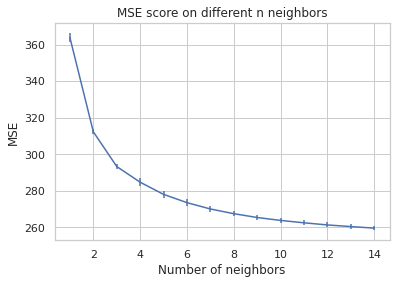

In [48]:
## Standardization for missing values imputation :
my_std = StandardScaler().fit(X)
X_std = pd.DataFrame(my_std.transform(X), 
                     columns=X.columns, index = X.index)

## missing values treatment : 
my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,15,1)}
cv = 4

# res = launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
## Save dictionnary of results : 
# with open(res_path+"set_n_KNN_impute_products"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"set_n_KNN_impute_products"+".pkl", "rb") as f :
        res = pickle.load(f)
fig_name = "set_n_KNN_impute_products"+".jpg"
plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

n_neighbors = 10 
## Impute missing values :
imputer = KNNImputer(n_neighbors=n_neighbors)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = my_std.inverse_transform(pred_std)
X = pd.DataFrame(pred, index = X.index, columns = X.columns)
X_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

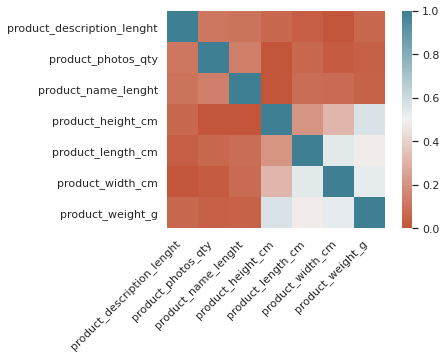

In [49]:
plot_heatmap_dist(X.corr())

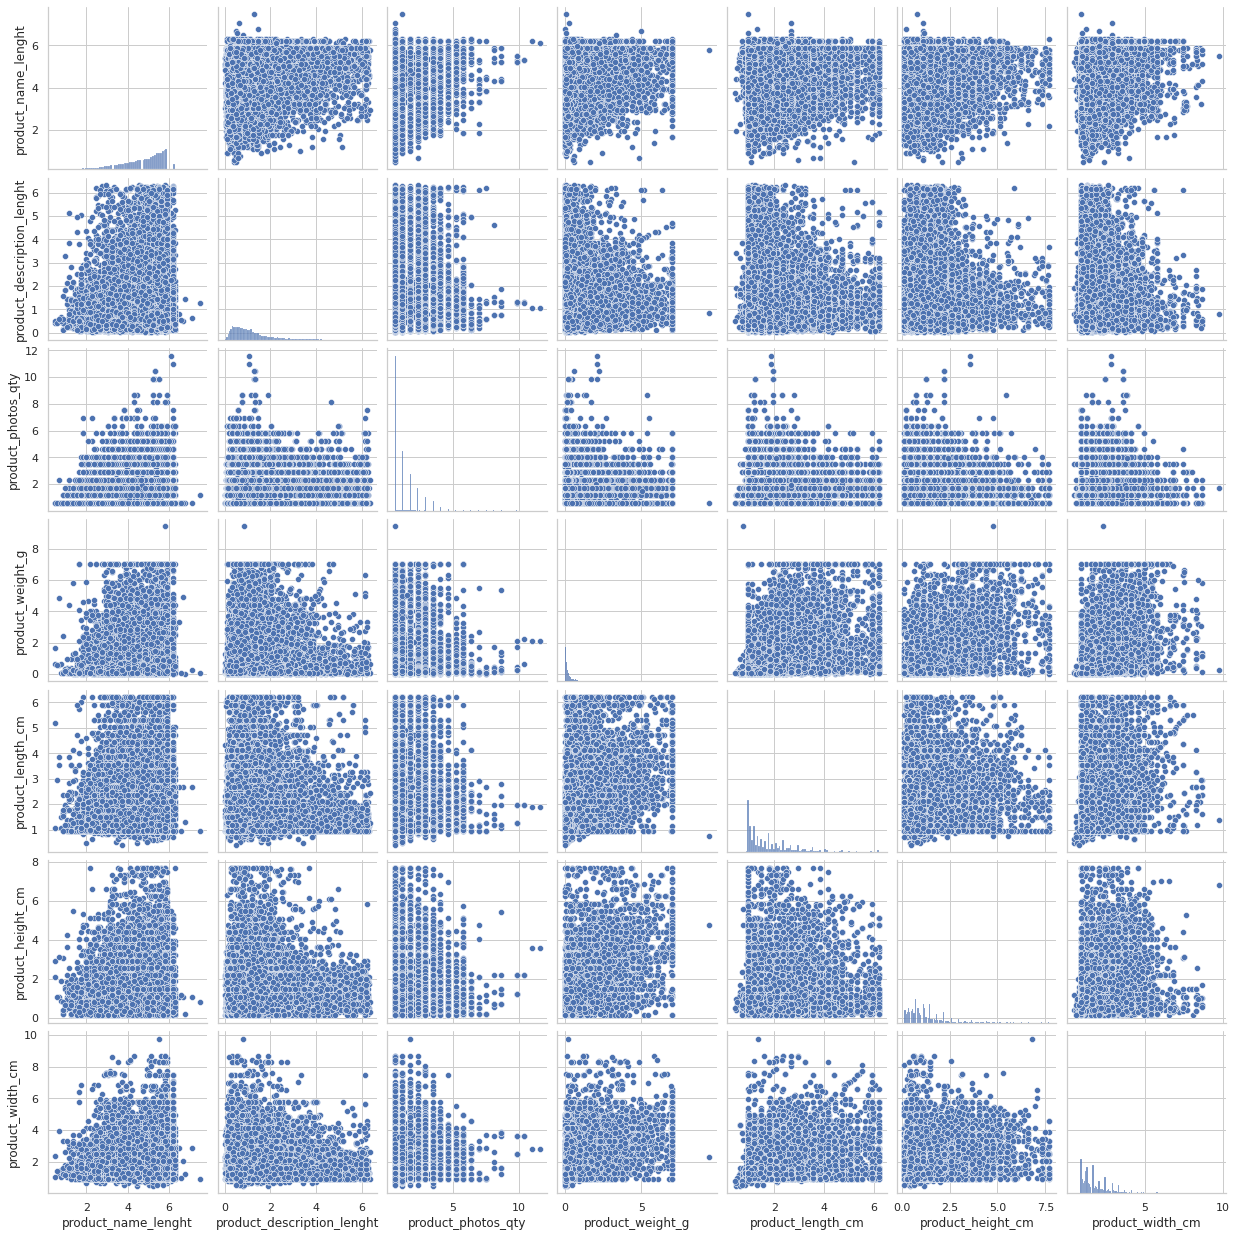

In [50]:
my_std2 = StandardScaler(with_mean = False)
X_std2 = pd.DataFrame(my_std2.fit_transform(X),
                      columns=X.columns, index=X.index) 
# tmp = pd.merge(y, X_std2, left_index=True, right_index=True)
sns.pairplot(X_std2)
plt.show()

### Réduction de dimension : 

Nous avons une classification (les catégories des produits), mais qui on l'air d'avoir un nombre très important de catégories (plus de 70). Je pense donc commence par faire une réduction de dimension (NMF et PCA) :

#### PCA

Je commence par la PCA : 

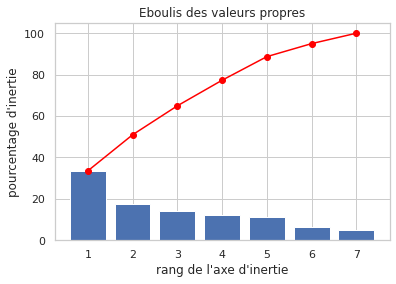

In [165]:
my_pca = PCA(n_components=X_std2.shape[1])
my_pca.fit(X_std2)
display_scree_plot(my_pca)

Les deux premiers axes de l'ACP  résument un peu plus de 50% de la variance. Ce n'est pas terrible. Essayons autre chose 

#### NMF

Quant à la NMF, il y a plusieurs hyperparamètres, mais il n'est pas possible de les choisir tel quel : il faudrait définir un score pour cela (je n'en trouve pas dans sklearn). Je réfléchis comment faire cela à partir de la norme de frobenius.


In [52]:
def frobenius_func(y, y_pred):
    return(np.linalg.norm(y-y_pred,"fro"))

def pseudo_cv_reduce_dim(X, my_meth, param_grid,my_score, cv = 5):
    ## MAP THE DICT OF LIST INTO LIST OF DICT :
    param_dirg = model_selection.ParameterGrid(param_grid)

    ## INITIALIZATION : 
    res = {} # dict of dict 
    res["params"]=[]
    for kwargs in param_dirg :
        res["params"].append(kwargs)
    dict_score = {}
    dict_time_fit = {}
    dict_time_predict = {}

    k_iter = 1
    ## SET FOLDS :
    kf = model_selection.KFold(n_splits = 5)
    CV_split_iterator = kf.split(X_,y) 

    ## LOOP ON FOLDS :
    for CV_train_range_index, CV_test_range_index in CV_split_iterator : 
        ## extract train
        train_index = X_.index[CV_train_range_index]
        train = X_.iloc[CV_train_range_index]
        ## LOOP ON PARAM NAMES (HERE ONLY 1)
        fold_key = "fold"+str(k_iter)
        ## init fold dict
        dict_score[fold_key] = []
        dict_time_fit[fold_key] = []
        dict_time_predict[fold_key] = []
        ## loop on different set of kwargs 
        for kwargs in param_dirg :
            ## SET PARAMS IN METH :
            my_meth.set_params(**kwargs)
            ## PREDICT TEST VALUES : 
            t = time.time()
            W = my_meth.fit_transform(train)
            dict_time_fit[fold_key].append(time.time() - t)
            t = time.time()
            H = my_meth.components_
            X_pred = np.dot(W,H)
            dict_score[fold_key].append(my_score(train, X_pred))
            dict_time_predict[fold_key].append(time.time() - t)
        k_iter += 1
    ## save in same shape as sklearn GridSearchCV     
    df_time_fit = pd.DataFrame(dict_time_fit)
    df_time_predict = pd.DataFrame(dict_time_predict)
    df_score = pd.DataFrame(dict_score)
    res["mean_fit_time"] = df_time_fit.mean(axis=1).values
    res["std_fit_time"] = df_time_fit.std(axis=1).values
    res["mean_score_time"] = df_time_predict.mean(axis=1).values
    res["std_score_time"] = df_time_predict.std(axis=1).values
    res["mean_test_score"] = df_score.mean(axis=1).values
    res["std_test_score"] = df_score.std(axis=1).values
    return(res)

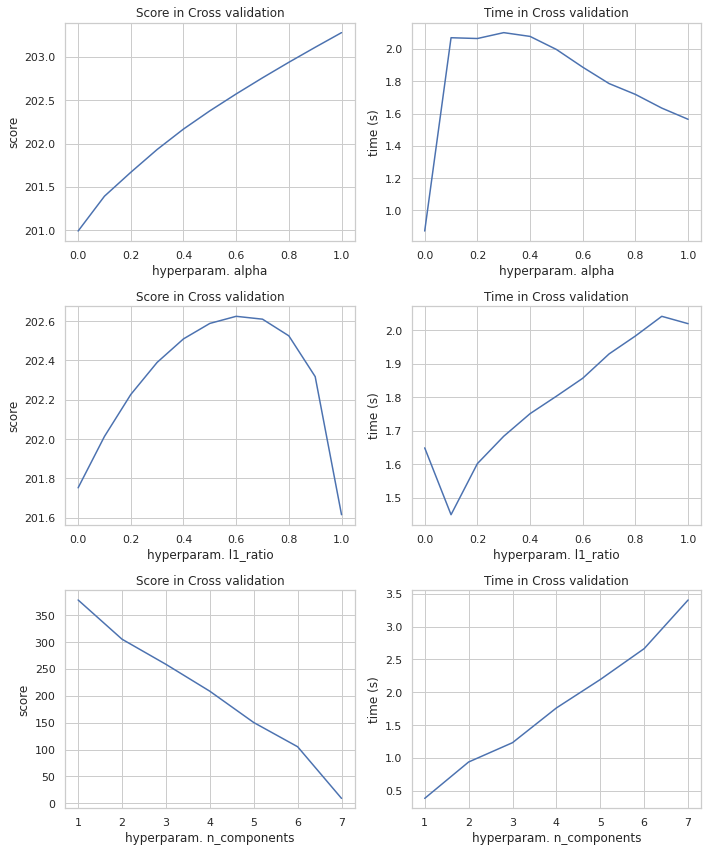

In [53]:
## should the plot be on logscale ?
dict_log_param = {"n_components" : False,
                  "alpha" : False,
                  "l1_ratio" : False,
                  "n_components" : False,
                  "classify__n_clusters" : False,
                  "classify__init" : False
                 }

## 1sr CV : 
param_grid = {'n_components': np.arange(1, X.shape[1]+1),
              'alpha': np.arange(0,1.1,0.1),
              'l1_ratio': np.arange(0,1.1,0.1)
             }
my_nmf = NMF(n_components=3, max_iter=1000, init ='nndsvdar')
my_score = frobenius_func
# res = pseudo_cv_reduce_dim(X_std2,my_nmf,param_grid, my_score, cv = 5)

# with open(res_path+"reduce_dim_products/NMF_res"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"reduce_dim_products/NMF_res"+".pkl", "rb") as f :
    res = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()

plt.savefig(res_path+"figures/"+"product_PCA_CV.jpg")

Même avec les meilleurs hyperparamètres (best_params = {"alpha" : 0.1, "l1_ratio" : 0.1}) cette réduction de dimension semble faire perdre beaucoup d'information :

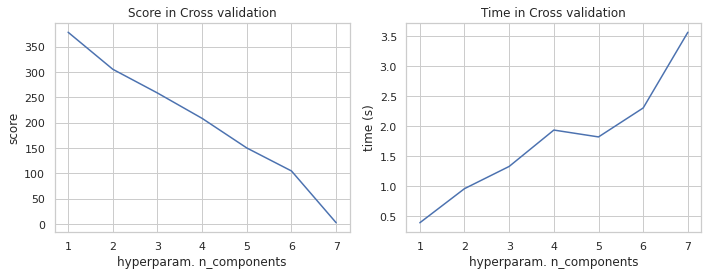

In [54]:
best_params = {"alpha" : 0.1, "l1_ratio" : 0.1}

## 1sr CV : 
param_grid = {'n_components': np.arange(1, X.shape[1]+1)}
my_nmf = NMF(max_iter=1000, init ='nndsvdar', **best_params)
my_score = frobenius_func
# res = pseudo_cv_reduce_dim(X_std2,my_nmf,param_grid, 
#                            my_score, cv = 5)

# with open(res_path+"reduce_dim_products/NMF_res_n_compo"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"reduce_dim_products/NMF_res_n_compo"+".pkl", "rb") as f :
    res = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()

Je vais donc comparer cette NMF avec une ACP

#### Etude de la réduction de dimension seule : 
Je propose de vérifier si ces projections sont sémantiques, en regardant la traduction des catégories de produit  : 

In [55]:
def plot_coeffs(my_meth, X_, X_name= "X"):
    '''
    from dim reduceur, plot coefficients of the 2 first axis
    and return coefficients on whole axis
    
    Parameters:
    -----------------------------------------
    my_meth = sklearn.decomposition methode like PCA of NMF 
    X_ = pd.DataFrame() of data to be reduced
    
    Returns:
    -----------------------------------------
    pd.DataFrame of coefficients
    '''
    my_meth.set_params(**{"n_components": X_.shape[1]})
    my_meth.fit(X_)

    coeffs = pd.DataFrame(my_meth.components_, columns = X_.columns,
                          index = ["ax_"+str(k) for k in np.arange(1,my_meth.n_components+1)])
    for colname in coeffs.columns :
        plt.scatter(x = coeffs.loc["ax_1", colname], 
                    y = coeffs.loc["ax_2", colname],
                    label = colname)
    plt.xlabel("coeff axis 1")
    plt.ylabel("coeff axis 2")
    my_meth_name = str(my_meth).split("(")[0]
    plt.title(my_meth_name+" on "+ str(X_name),fontsize=14)

    plt.legend()
    return(coeffs)

Il y a donc deux colonnes qui résument presque à elles seules la table, il s'agit de la longeur de la description du produit et du poids.Je jette un coup d'oeil à l'ACP : 

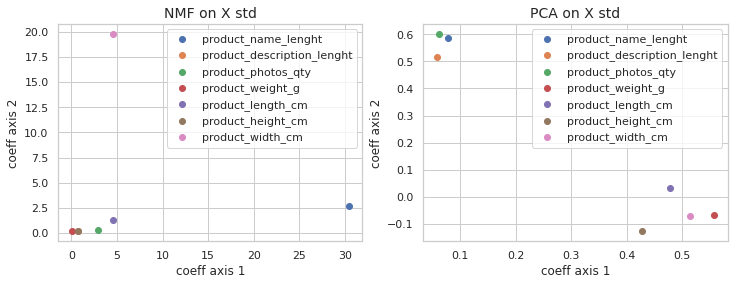

In [56]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
coeff_nmf = plot_coeffs(NMF(init = "random", max_iter = 10000,**best_params),X_std2, "X std")
plt.subplot(1,2,2)
coeffs_pca = plot_coeffs(PCA(),X_std2, "X std")
plt.savefig(res_path+"figures/"+"product_PCA_coeffs.jpg")
plt.show()

Le premier axe de la nmf est principalement constitué de la longueur du nom du produit, avec un poids 6 fois plus petit pour les autres variables. Le deuxième axe est tiré par la longueur du produit. Les autre colonnes ont des poids négligeables. 

L'ACP quant à elle regroupe les variables en deux catégories : 
* les dimensions du produit : longueur, largeur, hauteur, épaisseur. 
* les méta-données : la longueur du nom du produit, la longueur de la description, et la qualité de la photo

Lorsque les données sont réduite, on voit qu'il y avait clairement un effet d'échelle, c'était une bonne idée de réduire les données (X_std2)

Pour la suite, je propose de plutôt garder les résultats de l'ACP. En effet, je me rappelle bien qu'il faut un produit qui puisse être exploité par l'équipe marketing d'Olist, ainsi, je pense qu'il est pertinent de réduire la base de données "produit" avec l'ACP (car sémantique simple d'interprétation) pour permettre le traitement automatique de cette table. Par cela, j'entends lancer une ACP sur les deux groupe, pour avoir une projection à une dimension des variables "dimensions" et "description", et en faire deux variables sur lesquelles projeter les commandes.

In [57]:
def get_X_missing_vals_imputed(products, std = False):
    ## extract numeric table with id as index
    X = products.copy()
    X = X.set_index("product_id")
    X = X.loc[:,~(X.dtypes == object)]
    ## Standardize 
    my_std = StandardScaler().fit(X)
    X_std = pd.DataFrame(my_std.transform(X), columns=X.columns, index=X.index)
    n_neighbors = 10 
    ## Impute missing values :
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_std = imputer.fit_transform(X_std)
    X_std = pd.DataFrame(X_std, index = X.index, columns = X.columns)
    if std :
        return(X_std)
    else :
        ## Inverse-standardize : 
        X = my_std.inverse_transform(X_std)
        X = pd.DataFrame(X, index = X_std.index, columns = X_std.columns)
        return(X)


In [58]:
dimension_vars = ['product_weight_g', 'product_length_cm',       
                  'product_height_cm', 'product_width_cm']
description_vars = ['product_name_lenght', 'product_description_lenght',
                    'product_photos_qty']

def get_coeffs_project2d_products(products): 
    
    X_std = get_X_missing_vals_imputed(products, std = True)
    
    X_dimension = X_std.loc[:,dimension_vars]
    X_description = X_std.loc[:,description_vars]

    my_pca = PCA(n_components=1)
    my_pca.fit(X_dimension)
    dimension_coeffs = pd.Series(my_pca.components_[0], index = dimension_vars)
    my_pca.fit(X_description)
    description_coeffs = pd.Series(my_pca.components_[0], index = description_vars)
    return(dimension_coeffs, description_coeffs)

dimension_coeffs, description_coeffs = get_coeffs_project2d_products(products)

print(dimension_coeffs, "\n")
print(description_coeffs)

##TODO : coeffs to be revaluated every year, otherwize, use pre-computed coeffs
def project2d_products(products, coeffs, var) :
    dimension_vars, description_vars = var
    dimension_coeffs = coeffs[dimension_vars]
    description_coeffs = coeffs[description_vars]
    X_std = get_X_missing_vals_imputed(products, std = True)
    ## project on coeffs
    product_dimension = np.dot(X_std.loc[:,dimension_vars],dimension_coeffs)
    product_dimension = pd.Series(product_dimension, name="product_dimension",
                                 index = X_std.index)
    product_description = np.dot(X_std.loc[:,description_vars],description_coeffs)
    product_description = pd.Series(product_description, name="product_description",
                                 index = X_std.index)
    ## concat on index = product_id
    res = products.copy()
    res = res.set_index("product_id")
    res = pd.merge(res["product_category_name"], product_dimension, left_index=True, right_index=True)
    res = pd.merge(res, product_description, left_index=True, right_index=True)
    return(res)

coeffs = pd.concat(get_coeffs_project2d_products(products))
my_products = project2d_products(products, coeffs=coeffs,
                                 var=(dimension_vars, description_vars))

coeffs.to_csv(res_path+"products_items_coeffs_PCA.csv")

product_weight_g     0.560379
product_length_cm    0.478652
product_height_cm    0.433100
product_width_cm     0.518933
dtype: float64 

product_name_lenght           0.587492
product_description_lenght    0.537568
product_photos_qty            0.604875
dtype: float64


In [59]:
coeffs = pd.read_csv(res_path+"products_items_coeffs_PCA.csv",index_col=0, squeeze=True)
dimension_coeffs = coeffs[dimension_vars]
dimension_coeffs

product_weight_g     0.560379
product_length_cm    0.478652
product_height_cm    0.433100
product_width_cm     0.518933
Name: 0, dtype: float64

Ensuite, il y a un nombre trop grand de catégories de produits. Je propose de les regrouper un nombre plus restreint de méta-catégories pour limiter le fléau de la dimension, et faciliter l'interprétation.
### Clustering sur les catégories de produit 
#### Kmeans

Je commence par évaluer le nombre de cluster approprié par un kmeans. En effet, je pense qu'une première approche semi-suppervisée permet de voir comment bien résumer les 73 catégories (et voir si c'est pertinent de de le faire).

Je me suis en grande partie inspirée de ce code pour écrire ce qui suit : https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html



{'classify__init': 'k-means++', 'classify__n_clusters': 1}

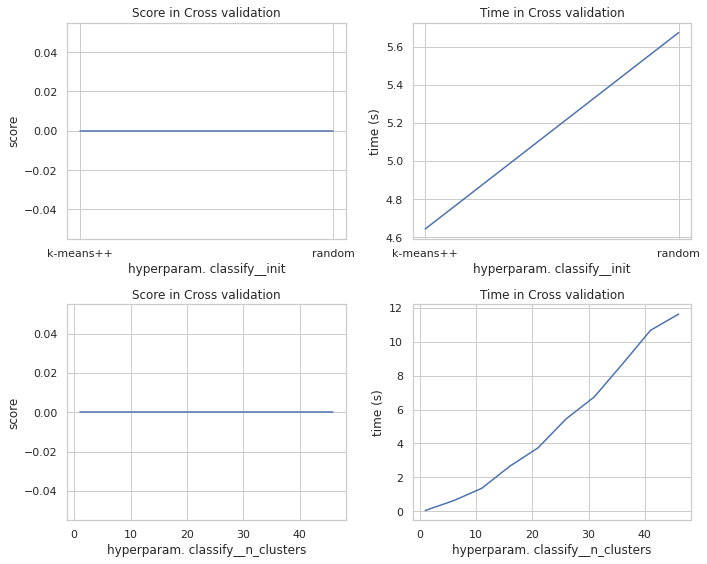

In [60]:
## 1st pipe - kmeans
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('classify', KMeans(n_clusters = 10, max_iter=1000))
    ])

param_grid = [{ 
                'classify__n_clusters': np.arange(1,50,5), 
                'classify__init':["k-means++","random"]m
}]

# grid = GridSearchCV(pipe1, param_grid = param_grid,
#                     n_jobs=5, cv = 5, scoring= "accuracy")
# grid.fit(X,y)
# ## Save dictionnary of results : 
# res = grid.cv_results_
# with open(res_path+"reduce_dim_products/kmeans_res_accuracy_y"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)
# best_params = grid.best_params_
# with open(res_path+"reduce_dim_products/kmeans_best_params_accuracy_y"+".pkl", "wb") as f :
#     pickle.dump(best_params, f, pickle.HIGHEST_PROTOCOL)


with open(res_path+"reduce_dim_products/kmeans_res"+".pkl", "rb") as f :
    res = pickle.load(f)
with open(res_path+"reduce_dim_products/kmeans_best_params"+".pkl", "rb") as f :
    best_params = pickle.load(f)

plot_cv_res(res,dict_log_param)
plt.tight_layout()
best_params

Le score est nul ! J'essaie donc autrement (approche non supervisée, avec un score type "fowlkes_mallows_score")  

[0.337291   0.51016864]


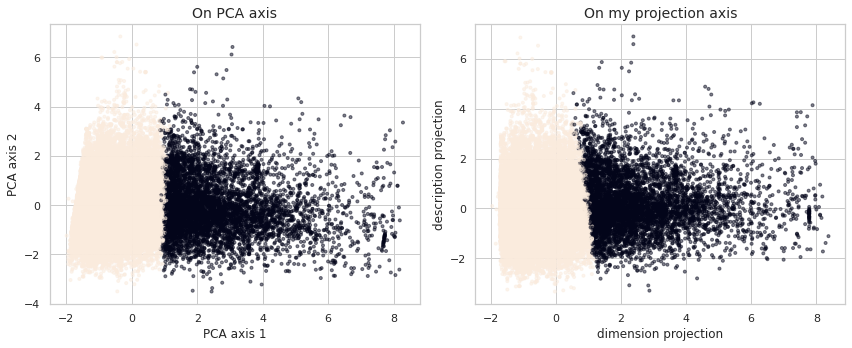

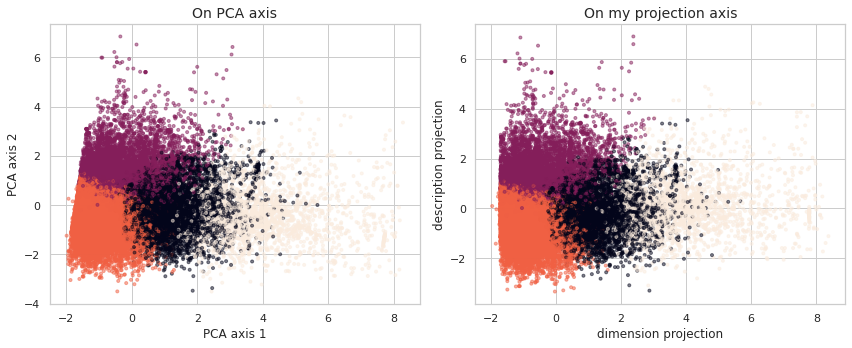

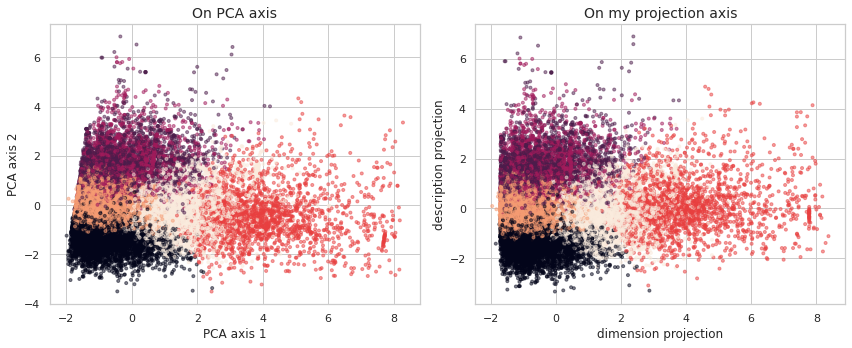

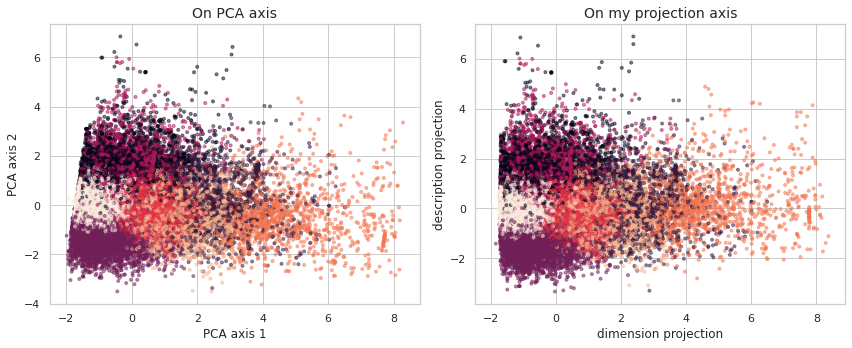

In [61]:

## 1st pipe - kmeans
pipe1 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('classify', KMeans(n_clusters = 10, max_iter=1000))
#     ('2d_projection',  PCA(n_components=2))
    ])

## vizualization on PCA axis :
my_pca = PCA(n_components=2).fit(X_std)
print(my_pca.explained_variance_ratio_.cumsum())
X_proj = my_pca.transform(X_std)

for n_clusters in np.arange(2,10,2):
    pipe1.set_params(**{"classify__n_clusters" : n_clusters})
    pipe1.fit(X)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(x=X_proj[:,0], y=X_proj[:,1], 
                c=pipe1["classify"].labels_, alpha = 0.5, marker=".") 
    plt.title("On PCA axis", fontsize=14)
    plt.xlabel("PCA axis 1")
    plt.ylabel("PCA axis 2")

    plt.subplot(1,2,2)
    plt.scatter(x=my_products["product_dimension"], y=my_products["product_description"],
                c=pipe1["classify"].labels_, alpha = 0.5, marker=".") 
    plt.title("On my projection axis", fontsize=14)
    plt.xlabel("dimension projection")
    plt.ylabel("description projection")
    plt.tight_layout()
    plt.show()
# ## vizualization on PCA axis :
# for n_clusters in np.arange(3,8):
#     pipe1.set_params(**{"classify__n_clusters" : n_clusters})
#     pipe1.fit(X)
#     X_proj = pipe1.transform(X)
#     plt.scatter(x=X_proj[:,0], y=X_proj[:,1], c=pipe1["classify"].labels_, alpha = 0.5, marker=".") 
#     # ["cluster"+str(k) for k in np.arange(1,n_clusters+1)]
#     plt.show()

Le problème est qu'il est alors très compliqué d'avoir un score pertinent pour choisir le nombre de cluster. D'autant que les catégories ne sont peut-être pas du tout caractérisées par les autres informations de cette table "products". Il serait donc sûrement intéressant de regrouper les catégories autrement, à méditer ##TODO

idée 1 : en regardant à l'échelle des commandes : si cat1 et cat2 souvent dans le même panier, je regroupe.

Je vais donc retourner à l'échelle "commande", où il me reste tables à exploiter. Pour rappel, mon aggrégation des tables ressemble actuellement à ça : 


In [62]:
my_orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status  order_purchase_date order_purchase_time  \
0    delivered  2017-10-02 00:00:00            10:56:33   
1    delivered  2018-07-24 00:00:00            20:41:37   
2    delivered  2018-08-08 00:00:00            08:38:49   

   order_dt_estimated_declared  order_dt_decalared_customer_carrier   price  \
0                     7.107488                             6.062650   29.99   
1                     5.355729                            12.039410  118.70   
2                    17.245498                             9.178113  159.90   

   freight_value  payment_installments payment_type  nb_payment_type  \
0           8.72                   1.0      voucher              2.0   
1          22.76                   1.0       boleto              1.0   
2          19.22                   3.0  credit_card              1.0   

   count_change_scores  review_score  count_review  count_comment_title  \
0                    1           4.0             1                    0   
1                    1           4.0             1                    1   
2                    1           5.0             1                    0   

   count_comment_message  
0                      1  
1                      1  
2                      0

## 3.2 Produit dans les commandes :

###  3.2.1 Étude descriptive

Pour rappel, j'ai déjà extrait les information de la table "order_items", telles que le prix. Je fais de nouveau appel à cette table uniquement pour faire le lien entre produit et commande. 
Déjà, combien y-a-t'il d'articles différents dans chaque commande ? 

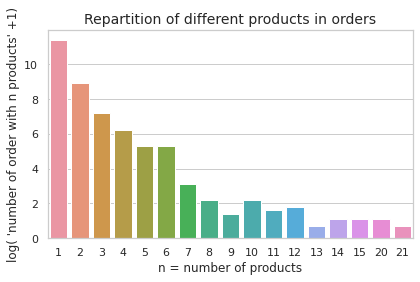

In [63]:
# tmp = order_items.order_id.value_counts()[(order_items.order_id.value_counts()>1).values]
tmp = order_items.order_id.value_counts().value_counts()
sns.barplot(x=tmp.index, y=np.log(tmp.values+1))
plt.title("Repartition of different products in orders",
          fontsize=14)
plt.xlabel("n = number of products")
plt.ylabel("log( 'number of order with n products' +1)")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"products_nb_in_orders.jpg")
plt.show()
# 98666 == np.unique(order_items.order_id).shape[0]

Il y a au plus {{max(tmp.index)}} produits dans chaque commande, et une majorité de commande n'a qu'un seul produit ({{np.round(tmp[1]/order_items.shape[0]*100,1)}} % des commandes).

Et comment se répartit le nombre d'apparition des produits dans les différentes commandes ? 

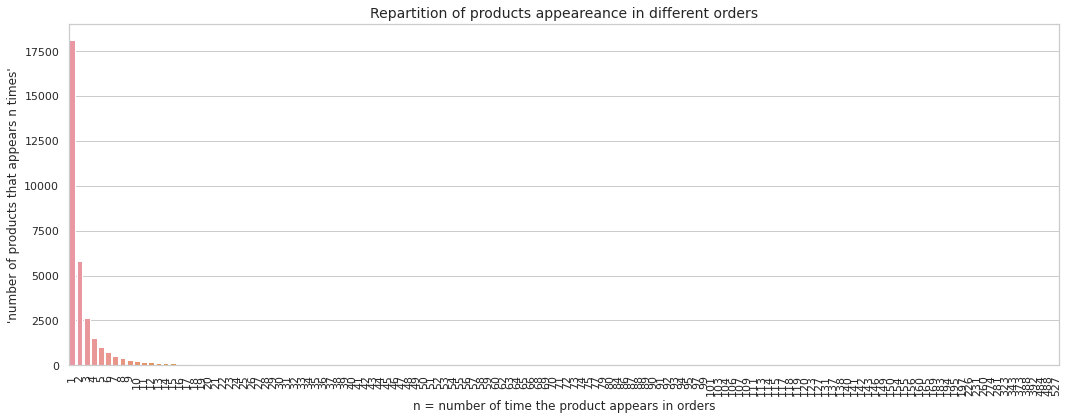

count    32951.000000
mean         3.418713
std         10.619709
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        527.000000
Name: product_id, dtype: float64


In [64]:

tmp = order_items.product_id.value_counts().value_counts()
plt.figure(figsize=(15,6))
sns.barplot(x=tmp.index, y=tmp.values)
plt.xticks(rotation=90)
plt.title("Repartition of products appeareance in different orders",
          fontsize=14)
plt.xlabel("n = number of time the product appears in orders")
plt.ylabel("'number of products that appears n times'")
plt.tight_layout()
plt.show()
product_nb_appearance = order_items.product_id.value_counts()
print(product_nb_appearance.describe())


On ne voit pas grand chose en échelle linéire, je fais une log-transform :

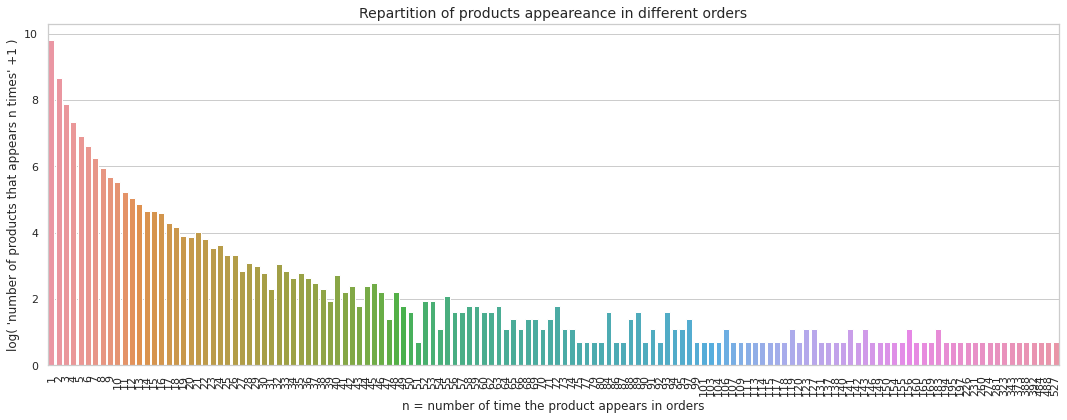

In [65]:
tmp = order_items.product_id.value_counts().value_counts()
plt.figure(figsize=(15,6))
sns.barplot(x=tmp.index, y=np.log(tmp.values+1))
plt.xticks(rotation=90)
plt.title("Repartition of products appeareance in different orders",
          fontsize=14)
plt.xlabel("n = number of time the product appears in orders")
plt.ylabel("log( 'number of products that appears n times' +1 )")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"products_nb_apperance_log.jpg")
plt.show()

## some descriptive statistics
n_max = 150 
nb_products_more_than_n = tmp[tmp.index>n_max].cumsum()[-1:].values[0]
percent_products_more_than = np.round(nb_products_more_than_n/
                                      np.unique(order_items.product_id).shape[0]*100,2)
products_more_than_n = order_items.product_id.iloc[np.where(order_items.product_id.value_counts()>n_max)]
nb_appearance_products_more_than = order_items[order_items.product_id.isin(products_more_than_n)].shape[0]


n_min = 4
nb_products_less_than_n = tmp[tmp.index<n_min].cumsum()[-1:].values[0]
percent_products_less_than = np.round(nb_products_less_than_n/
                                      np.unique(order_items.product_id).shape[0]*100,2)

n_min2 = 2
nb_products_less_than_n2 = tmp[tmp.index<n_min2].cumsum()[-1:].values[0]
percent_products_less_than2 = np.round(nb_products_less_than_n2/
                                      np.unique(order_items.product_id).shape[0]*100,2)

Certains produits apparaissent un très grand nombre de fois : 
* {{nb_products_more_than_n}} produits 
( {{ percent_products_more_than }} % des produits) 
apparaissent plus de {{n_max}} fois, ce qui représente
{{ np.round(nb_appearance_products_more_than/order_items.shape[0]*100,1) }} %
des produits commandés

Mais la majorité des produits n'apparait que dans quelques commandes :
* {{nb_products_less_than_n}} produits 
( {{ percent_products_less_than }} % des produits )
apparaissent moins de {{n_min}} fois,
* {{nb_products_less_than_n2}} produits 
( {{ percent_products_less_than2 }} % des produits )
apparaissent moins de {{n_min2}} fois,

Je propose d'ajouter des variables descriptives issues de ces répartitions dans la table "my_products". Cette table sera alors à actualiser régulièrement (tous les 3 mois ? ##TODO : evaluer les temps d'apparition des nouveaux produits, ou changement d'habitude) 

In [66]:
product_nb_app = order_items.product_id.value_counts()
my_quantile_classes = {"very_low":[1,0.95], "low":[0.95,0.75],
                       "medium_low" : [0.75,0.5],"medium_high" : [0.5,0.25],
                       "high" : [0.25,0.05], "very_high" : [0.05,0]}

## products never on orders : 
my_products.loc[:,"product_freq_buy"] = 0

for freq_class in my_quantile_classes.keys():
    q_max, q_min = my_quantile_classes[freq_class] 
    n_max = product_nb_app.quantile(q=q_max)
    n_min = product_nb_app.quantile(q=q_min)
    if ~(n_min == n_max) : 
        cond_max = np.where(product_nb_app<=n_max)
        cond_min = np.where(product_nb_app>n_min)
        if q_max == 1 :
            range_index = cond_max
        elif q_min == 0 :
            range_index = cond_min
        else :
            range_index = np.intersect1d(cond_min,cond_max)
    
        product_in_class = order_items.product_id.iloc[range_index].values
        my_products.at[product_in_class,"product_freq_buy"] = np.mean([q_min,q_max])
#         my_products.at[product_in_class,"product_freq_buy"] = freq_class

Je mets, dans la table ```my_products``` deux variables drapeau.
La première, "product_flag_ordered_alone" vaut : 
* 0 si le produit n'a jamais été commandé seul
* 1 si le produit a été commandé seul

Et la deuxième, "product_flag_never_ordered" prend les valeurs :
* 0 si le produit n'a jamais été commandé 
* 1 si le produit a été commandé au moins une fois

J'y ajoute aussi deux variables "price" qui correspondent au prix moyen et au prix de fret observés sur le produit :

In [67]:
## ordered alone
my_products.loc[:,"product_flag_ordered_alone"] = 0
range_index = np.where(order_items.product_id.value_counts()==1)
products_ordered_alone = order_items.product_id.iloc[range_index].values
products_ordered_alone = my_products.index.isin(products_ordered_alone)
my_products.at[products_ordered_alone,"product_flag_ordered_alone"] = 1
## never ordered
my_products.loc[:,"product_flag_never_ordered"] = 1
range_index = np.where(order_items.product_id.value_counts()>=1)
products_never_ordered = order_items.product_id.iloc[range_index].values
products_never_ordered = my_products.index.isin(products_never_ordered)
my_products.at[products_never_ordered,"product_flag_never_ordered"] = 0

## prices
tmp = order_items.groupby("product_id").mean()[['price', 'freight_value']]
tmp = tmp.add_prefix("product_")
tmp = tmp.reset_index()
my_products = pd.merge(my_products,tmp, on="product_id",how="left")

## set right type : 
my_products = my_products.astype({"product_category_name":"category"})

In [68]:
my_products.dtypes

product_id                      object
product_category_name         category
product_dimension              float64
product_description            float64
product_freq_buy               float64
product_flag_ordered_alone       int64
product_flag_never_ordered       int64
product_price                  float64
product_freight_value          float64
dtype: object

Ajout d'une colonne correspondant au nombre de produits dans la commande, dans ma table ```my_order``` : 

In [69]:
tmp = order_items.groupby("order_id").count()["product_id"].reset_index()
tmp = tmp.rename(columns={"product_id":"count_products"})
my_orders = pd.merge(my_orders,tmp, on="order_id",how="left")

###  3.2.2 Réduire la dimension des catégories de produits (73 initiales)
Il ne me reste plus qu'à voir s'il est possible de résumer les différentes variable de ```my_products``` avec les catégories des produits (ou un regroupement des catégories).

In [70]:
my_products.head(3)

product_id product_category_name  product_dimension  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria          -1.303164   
1  3aa071139cb16b67ca9e5dea641aaa2f                 artes          -0.293717   
2  96bd76ec8810374ed1b65e291975717f         esporte_lazer          -1.244654   

   product_description  product_freq_buy  product_flag_ordered_alone  \
0            -1.310268             0.000                           0   
1            -1.090214             0.000                           0   
2            -0.997539             0.975                           0   

   product_flag_never_ordered  product_price  product_freight_value  
0                           1          10.91                   7.39  
1                           1         248.00                  17.99  
2                           0          79.80                   7.82

#### Deuxième tentative de clustering sur les catégories de produit

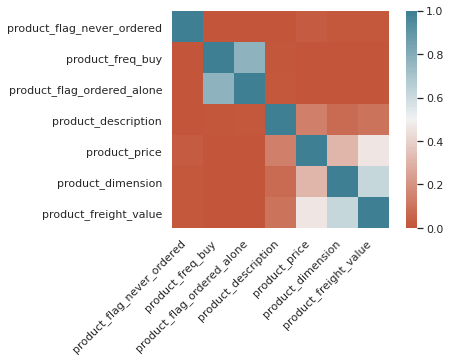

In [71]:
# (my_products.dtypes == float) | (my_products.dtypes == int)
X = my_products.loc[:,my_products.dtypes != "category"]
X = get_X_missing_vals_imputed(X, std = False)
my_std = StandardScaler().fit(X)
X_std = pd.DataFrame(my_std.transform(X),
                     index=X.index, columns=X.columns) 

y = my_products[["product_id","product_category_name"]]
y = y.set_index("product_id").astype("object")
y = y.fillna("missing")
y = y.astype("category")

plot_heatmap_dist(X_std.corr())

La variable "freight_value" étant corrélée au prix et à la dimension, et la variable "flag_ordered_alone" fortement corrélée à "freq_buy", je les retire pour la suite : 

In [72]:
X = X.drop(columns=["product_freight_value", "product_flag_ordered_alone"])
X_std = X_std.drop(columns=["product_freight_value", "product_flag_ordered_alone"])

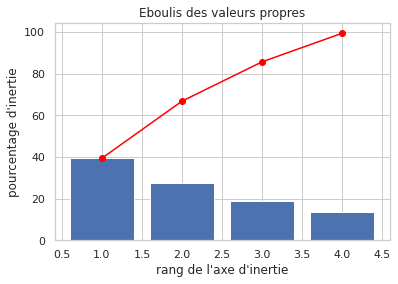

In [73]:
pipe2 = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ('reduce_dim', PCA(n_components=X.shape[1]-1))
    ])

pipe2.fit(X)
my_pca = pipe2["reduce_dim"]
display_scree_plot(my_pca)

Les 3 premiers axes semblent expliquer plus de 80% de la variance.

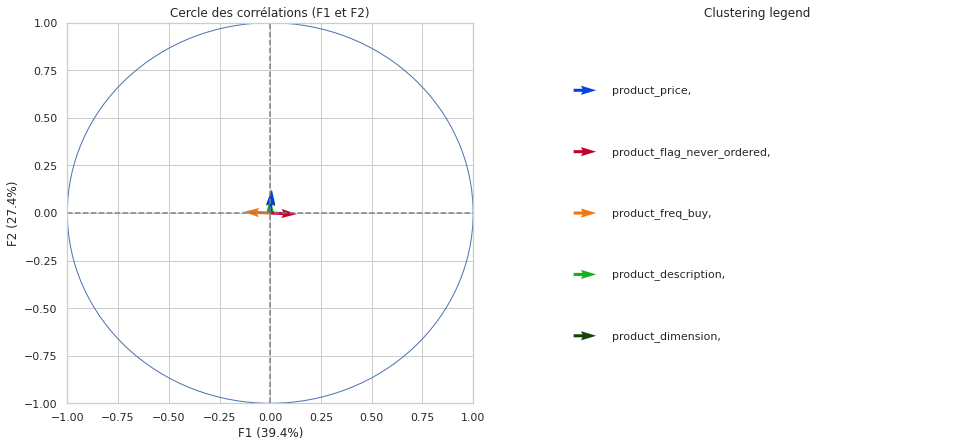

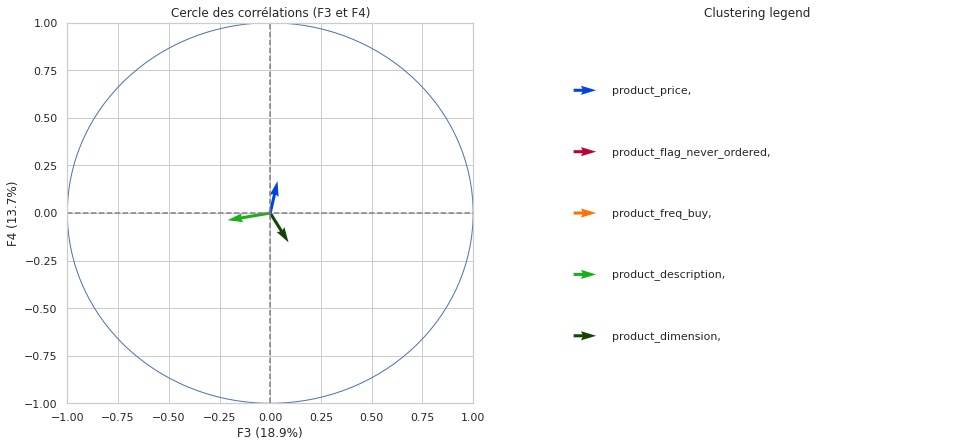

In [74]:
fig_name = None
figsize = (8,7)
pcs = my_pca.components_
## to color variables
clustering = pd.Series(range(len(X.columns)),
                       index=X.columns, dtype="category")
display_circles(pcs, 6, my_pca, [(0,1)], 
                labels = None, clustering=clustering,
                figsize = figsize, fig_name=fig_name)
display_circles(pcs, 6, my_pca, [(2,3)], 
                labels = None, clustering=clustering, 
                figsize = figsize, fig_name=fig_name)

product_dimension  product_description  product_freq_buy  \
ax_1           0.029759            -0.009493         -0.706025   
ax_2           0.633184             0.387249          0.032508   
ax_3           0.389603            -0.907469          0.021759   
ax_4          -0.668131            -0.162602          0.010638   
ax_5           0.001334            -0.003089         -0.707025   

      product_flag_never_ordered  product_price  
ax_1                    0.706198       0.042858  
ax_2                   -0.029560       0.668719  
ax_3                   -0.016260       0.154830  
ax_4                   -0.007452       0.725942  
ax_5                   -0.707171       0.003637

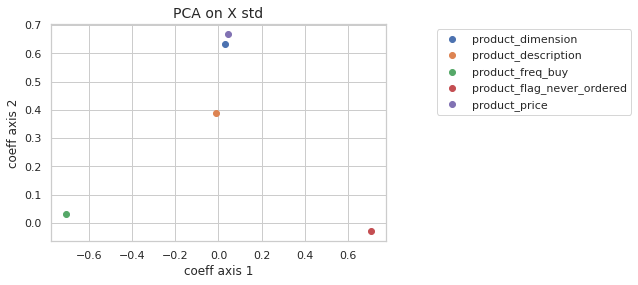

In [75]:
coeff_pca = plot_coeffs(my_pca, X_std, "X std")
plt.legend(bbox_to_anchor=(1.75, 1))
coeff_pca
# pd.DataFrame(pcs, columns = X.columns, 
#              index = ["axis"+str(k) for k in np.arange(1,pcs.shape[0]+1)])


Les deux premiers axes sont constitués d'une aggrégation de variable : 
* le premier axe correspond à un contribution positive pour le "flag_never_ordered" et une contribution négative de "freq_buy"
* le deuxième axe correspond à la somme des variable de prix, et de dimension, avec une petite contribution de la méta-variable "description" 
* le troisième axe correspond à une forte contribution négative de la variable "description", avec une petite influence positive de "dimension"
* le quatrième axe est principalement la somme de "+prix" et "-dimension".

Je vais regarder si, sur les deux premiers axe de cette pca, on voit se dégager des formes dans les catégories :

In [76]:
X_proj = my_pca.transform(X_std)
X_proj = pd.DataFrame(X_proj, index=X.index,
             columns= ["axis"+str(k) for k in np.arange(1,X_proj.shape[1]+1)])

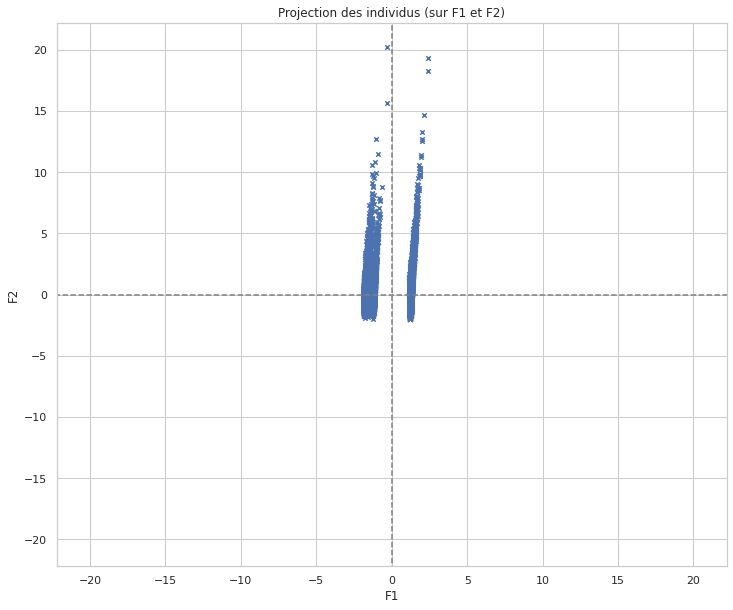

In [77]:
display_factorial_planes(X_proj, 2, my_meth, [(0,1), (2,3)], ind_labels=None, 
                         alpha=1, clustering=None, figsize=(12,10) )

In [78]:

n_comp = 2
axis_ranks = [(0,1),(2,3)]
clustering = y.product_category_name
# Projection des individus
X_proj = my_pca.transform(X_std)
X_proj = pd.DataFrame(X_proj, index = X.index, 
                           columns = ["axis"+ str(k) for k in np.arange(1,X_proj.shape[1]+1)])

In [79]:
figsize = (10,4)
axis_ranks = [(0,1),(2,3)]
# n_comp = max(list(sum(axis_ranks, ())))+1
# plot_PCA_proj_of_clusters(X_proj, my_meth, [(0,1), (2,3)], ind_labels=None, 
#                          alpha=1, clustering=clustering, figsize=figsize)

Il ne semble pas du tout se dégager des formes assez représentatives de groupes de catégories ! Mon idée était, si ça avait été le cas, de contruire une "matrice de corrélation", correspondant à la distance entre les projections en norme infini (ce que j'aurais voulu retrouver, c'est bien la forme de ma projection). Néanmoins, je peux au moins regrouper les catégories à la main ... 

In [80]:
all_cat = pd.Series(y["product_category_name"].cat.categories, name ="product_category_old" )
new_cat = pd.Series(y["product_category_name"].cat.categories, name ="product_category_name" )
for idx in all_cat.index :
    cat = all_cat[idx]
    new_cat.at[idx] = cat.split("_")[0]
rename_cat = pd.merge(all_cat,new_cat, left_index=True, right_index=True)
rename_cat = rename_cat.set_index("product_category_old").to_dict()
rename_cat['la']="cuisine"
y = y.replace(rename_cat["product_category_name"])
y = y.astype("category").reset_index()

In [81]:
my_products = my_products.drop(columns="product_category_name")
my_products = pd.merge(y,my_products, on="product_id",how="left")

In [82]:
clustering = y.product_category_name
# plot_PCA_proj_of_clusters(X_proj, my_meth, [(0,1), (2,3)], ind_labels=None, 
#                          alpha=1, clustering=clustering, figsize=figsize)

Bon, cette projection PCA ne nous donne vraiment pas grand chose... Néanmoins, ce travail de regroupement me permets de réduire à {{len(np.unique(y2))}} catégories. Je vais juste garder les 4 premiers axes de la PCA, avec cette classification un peu plus grossière, comme espace de projection des produits. 

In [83]:
y2_dummies = pd.get_dummies(my_products["product_category_name"])
y2_dummies = y2_dummies.add_prefix("product_category_")
y2_dummies = y2_dummies.set_index(y["product_id"]).reset_index()
y2_dummies
# y2_dummies = y2_dummies.reset_index()
# my_products = pd.merge(my_products, y2_dummies, on="product_id", how="left")
# LR = LogisticRegression(random_state=0)
# LR.fit(X=y2_dummies,y=np.ravel(y2.values))
# y4 = LR.predict(y2_dummies)

product_id  product_category_agro  \
0      1e9e8ef04dbcff4541ed26657ea517e5                      0   
1      3aa071139cb16b67ca9e5dea641aaa2f                      0   
2      96bd76ec8810374ed1b65e291975717f                      0   
3      cef67bcfe19066a932b7673e239eb23d                      0   
4      9dc1a7de274444849c219cff195d0b71                      0   
...                                 ...                    ...   
32946  a0b7d5a992ccda646f2d34e418fff5a0                      0   
32947  bf4538d88321d0fd4412a93c974510e6                      0   
32948  9a7c6041fa9592d9d9ef6cfe62a71f8c                      0   
32949  83808703fc0706a22e264b9d75f04a2e                      0   
32950  106392145fca363410d287a815be6de4                      0   

       product_category_alimentos  product_category_artes  \
0                               0                       0   
1                               0                       1   
2                               0                       0   
3                               0                       0   
4                               0                       0   
...                           ...                     ...   
32946                           0                       0   
32947                           0                       0   
32948                           0                       0   
32949                           0                       0   
32950                           0                       0   

       product_category_artigos  product_category_audio  \
0                             0                       0   
1                             0                       0   
2                             0                       0   
3                             0                       0   
4                             0                       0   
...                         ...                     ...   
32946                         0                       0   
32947                         0                       0   
32948                         0                       0   
32949                         0                       0   
32950                         0                       0   

       product_category_automotivo  product_category_bebes  \
0                                0                       0   
1                                0                       0   
2                                0                       0   
3                                0                       1   
4                                0                       0   
...                            ...                     ...   
32946                            0                       0   
32947                            0                       0   
32948                            0                       0   
32949                            0                       0   
32950                            0                       0   

       product_category_bebidas  product_category_beleza  ...  \
0                             0                        0  ...   
1                             0                        0  ...   
2                             0                        0  ...   
3                             0                        0  ...   
4                             0                        0  ...   
...                         ...                      ...  ...   
32946                         0                        0  ...   
32947                         0                        0  ...   
32948                         0                        0  ...   
32949                         0                        0  ...   
32950                         0                        0  ...   

       product_category_pcs  product_category_perfumaria  \
0                         0                            1   
1                         0                            0   
2                         0                            0   
3                         0 

Le top aurait été ici de faire du target encoding [comme sur cette implémentation](https://contrib.scikit-learn.org/category_encoders/targetencoder.html#target-encoder), cependant, comme les catégories sont très mal représentées par les features, cela ne pourra pas marcher.

In [84]:
### errors on these, look if i can use it ?
# from category_encoders.target_encoder import TargetEncoder
# enc = TargetEncoder()
# enc.fit_target_encoding(X,y3)

# from category_encoders.woe import WOEEncoder
# enc = WOEEncoder()
# enc.fit_transform(y3,np.ravel(y2.values))

In [85]:
y2_dummies.describe(percentiles=[])

product_category_agro  product_category_alimentos  \
count           32951.000000                32951.000000   
mean                0.002246                    0.005645   
std                 0.047337                    0.074920   
min                 0.000000                    0.000000   
50%                 0.000000                    0.000000   
max                 1.000000                    1.000000   

       product_category_artes  product_category_artigos  \
count            32951.000000              32951.000000   
mean                 0.002246                  0.002762   
std                  0.047337                  0.052480   
min                  0.000000                  0.000000   
50%                  0.000000                  0.000000   
max                  1.000000                  1.000000   

       product_category_audio  product_category_automotivo  \
count            32951.000000                 32951.000000   
mean                 0.001760                     0.057661   
std                  0.041918                     0.233106   
min                  0.000000                     0.000000   
50%                  0.000000                     0.000000   
max                  1.000000                     1.000000   

       product_category_bebes  product_category_bebidas  \
count             32951.00000              32951.000000   
mean                  0.02789                  0.002458   
std                   0.16466                  0.049520   
min                   0.00000                  0.000000   
50%                   0.00000                  0.000000   
max                   1.00000                  1.000000   

       product_category_beleza  product_category_brinquedos  ...  \
count             32951.000000                 32951.000000  ...   
mean                  0.074171                     0.042821  ...   
std                   0.262053                     0.202457  ...   
min                   0.000000                     0.000000  ...   
50%                   0.000000                     0.000000  ...   
max                   1.000000                     1.000000  ...   

       product_category_pcs  product_category_perfumaria  \
count           32951.00000                 32951.000000   
mean                0.00091                     0.026342   
std                 0.03016                     0.160153   
min                 0.00000                     0.000000   
50%                 0.00000                     0.000000   
max                 1.00000                     1.000000   

       product_category_pet  product_category_portateis  \
count          32951.000000                32951.000000   
mean               0.021820                    0.001244   
std                0.146099                    0.035253   
min                0.000000                    0.000000   
50%                0.000000                    0.000000   
max                1.000000                    1.000000   

       product_category_relogios  product_category_seguros  \
count               32951.000000              32951.000000   
mean                    0.040333                  0.000061   
std                     0.196741                  0.007791   
min                     0.000000                  0.000000   
50%                     0.000000                  0.000000   
max                     1.000000                  1.000000   

       product_category_sinalizacao  product_category_tablets  \
count                  32951.000000              32951.000000   
mean                       0.002822                  0.000273   
std                        0.053052                  0.016525   
min                        0.000000                  0.000000   
50%                        0.000000                  0.000000   
max                        1.000000                  1.000000   

       product_category_telefonia  product_category_utilidades  
count                32951.000000                 32951

Je sais qu'avec des méthodes liéaires, mes catégories séparent mal mes données. Néanmoins, je propose de regarder dans les 4 axes de l'acp ce que donne une ANOVA :

for axis1 in log space :


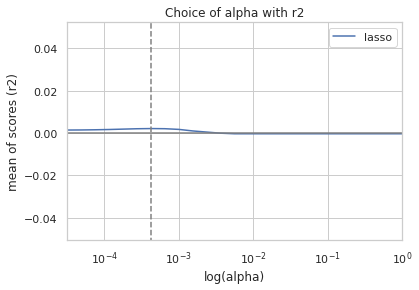

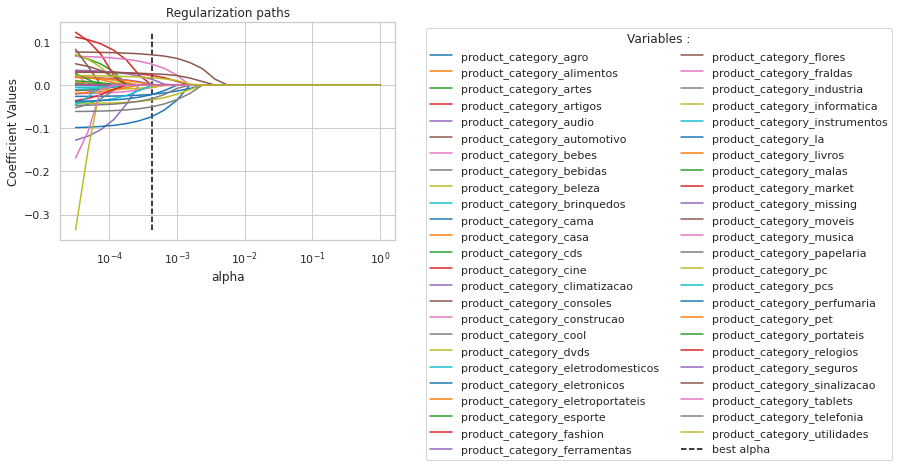

for axis2 in log space :


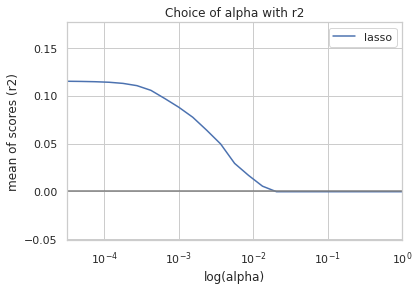

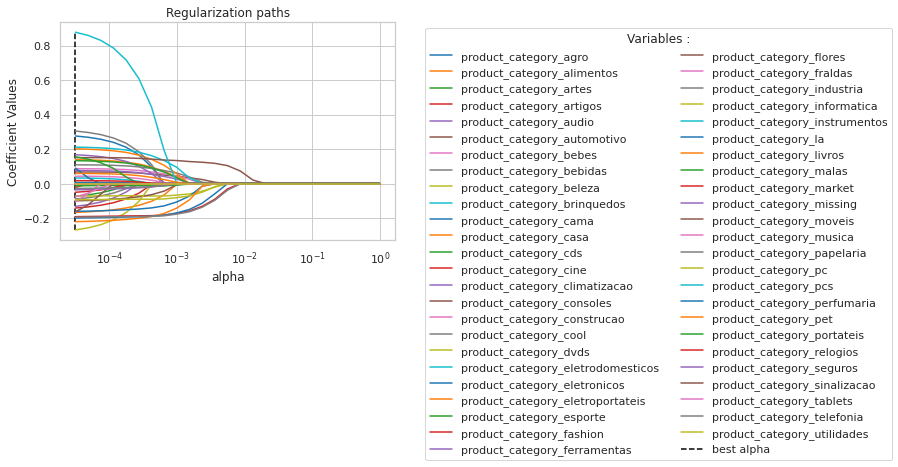

for axis3 in log space :


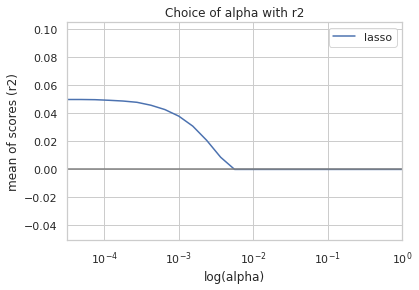

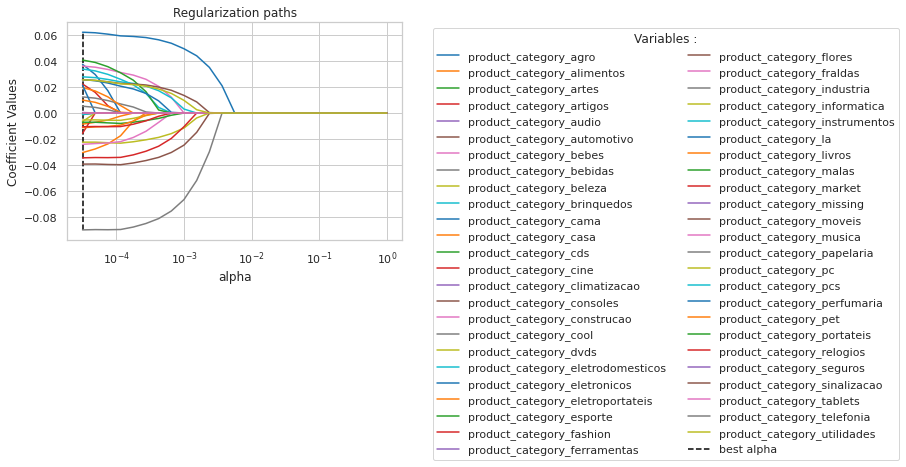

for axis4 in log space :


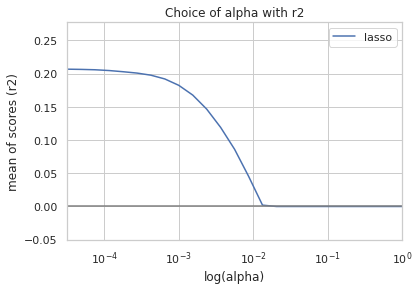

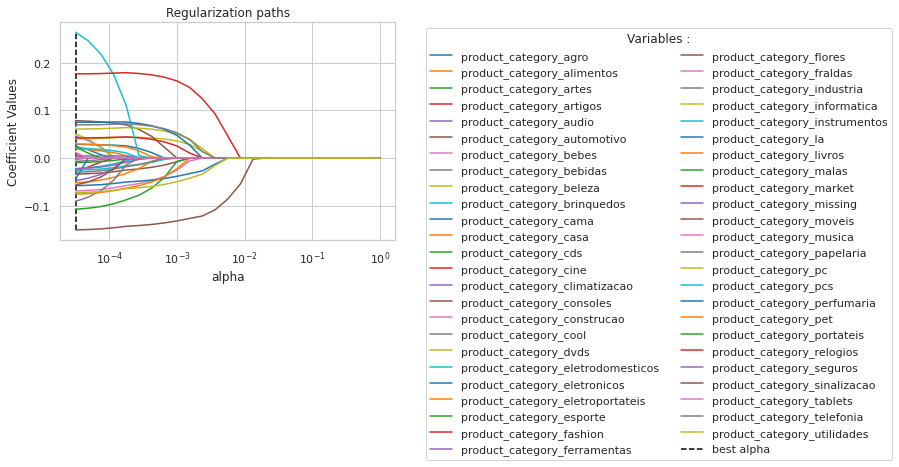

In [87]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
               "lasso" : linear_model.Lasso(),
              }

dict_param_grid["lasso"] = np.logspace(-4.5, 0, 25)

for var in ["axis"+str(k+1) for k in range(4)]:
#     var = "axis1"
    X_ = y2_dummies.set_index("product_id").astype(int)
    y_ = X_proj[var]
    cte = max(-min(y_[y_<0]),0)
    y_ = np.log(y_ + cte + 1)
    print("for", var, "in log space :")
    res = compare_regressions(X_, y_, {"lasso" : linear_model.Lasso(max_iter=10000)}, 
                              dict_param_grid, score_name="r2", fig_name=None)
    plt.show()
    ## regul paths :
    model_name = "lasso"
    legend_kwargs = {"loc" : "upper right","bbox_to_anchor":(2.5, 1), "ncol":2}
    plot_regul_paths(alpha_values = dict_param_grid[model_name], lm_model = dict_models[model_name], 
                     X_ = X_, y_ = y_, best_alpha=res.loc[model_name, "best_alpha"],
                     var_names = X_.columns, legend_kwargs=legend_kwargs)
    plt.show()


En effet, l'ANOVA donne un score vraiment très mauvais. Il est vraiment étonnant que les axes supérieurs expliquent mieux les classes.

Bon, je propose donc de rajouter ces colonnes "produits" aux commandes. Pour cela, je propose de faire la somme des colonnes, autant numériques que catégorielles. Pour faire le liens, j'utilise la table order_items

In [117]:
## Numerical var of products added in orders :
# tmp = pd.merge(link_order_product, my_products.drop("product_category_name"), 
#                on="product_id", how="left")
tmp = pd.merge(link_order_product, my_products, 
               on="product_id", how="left")
tmp = tmp.drop(columns='product_id')
tmp = tmp.groupby("order_id").sum()
tmp = tmp.add_prefix("sum_")
tmp = tmp.reset_index()
my_orders = pd.merge(my_orders,tmp, on="order_id", how="left")

In [88]:
## create a df with order, id, and the binary cat variables to be sum
# tmp = my_products.loc[:,my_products.dtypes == "category"].copy()
tmp = y2_dummies.set_index("product_id")
tmp = tmp.astype(int).reset_index()
tmp.at[:,"product_id"]=my_products.product_id.values
tmp = pd.merge(order_items[["order_id","product_id"]], tmp, 
               on="product_id", how="right")
tmp = tmp.drop(columns="product_id")

## gather on order and sum :
tmp2 = tmp.groupby("order_id").sum()
tmp2 = tmp2.astype("category")
my_orders2 = pd.merge(my_orders,tmp2, on="order_id",how="left")

Je regarde en vitesse la répartition de ces nouvelles variables de l'échelle "commande" :

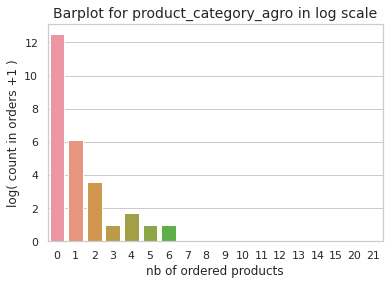

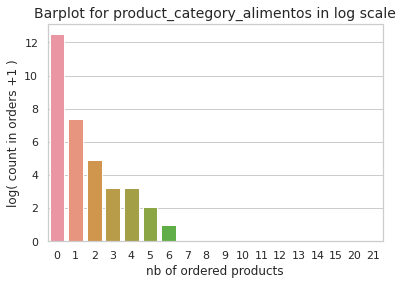

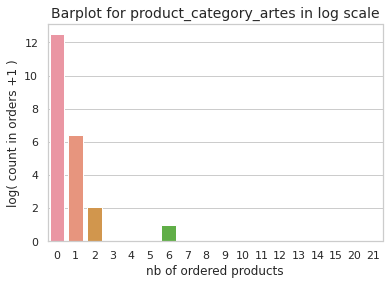

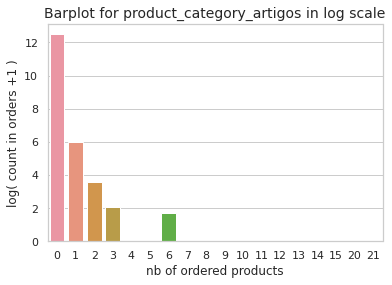

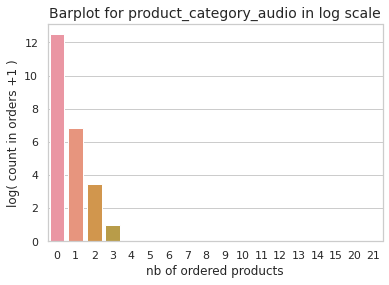

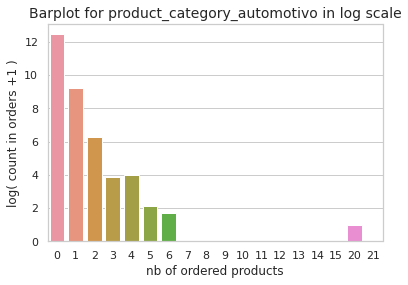

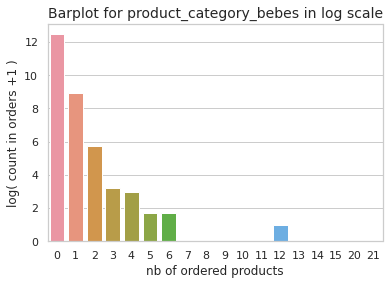

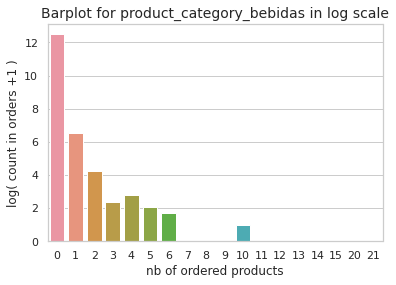

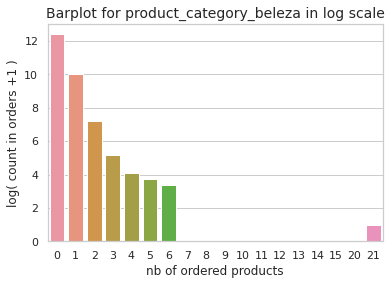

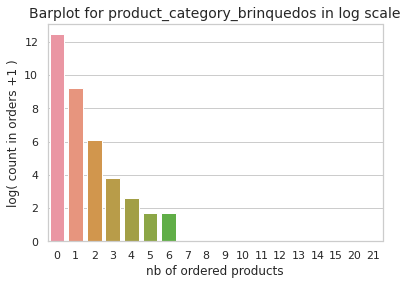

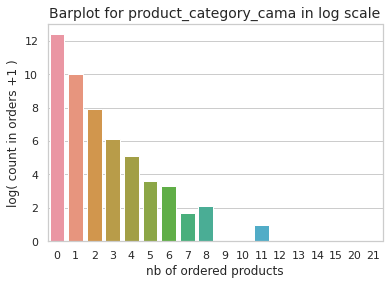

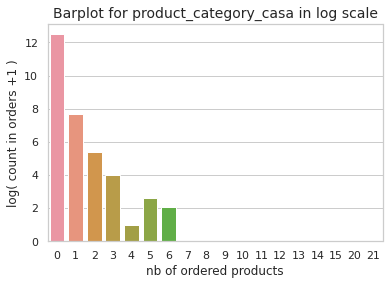

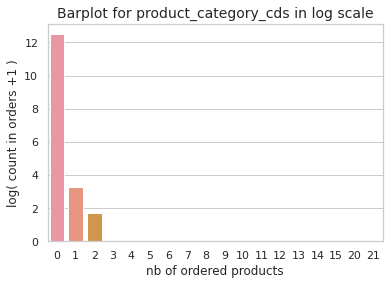

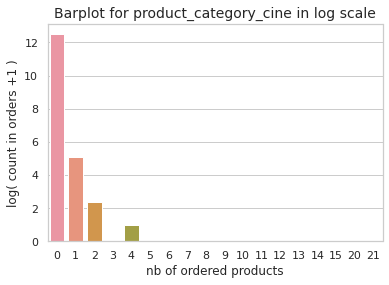

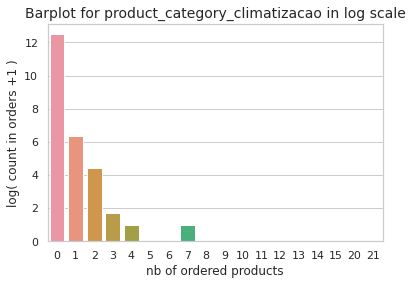

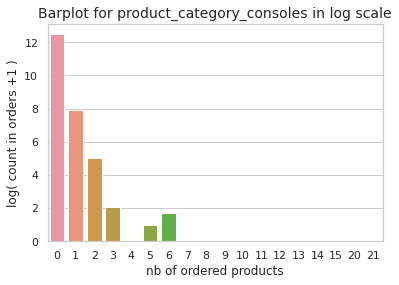

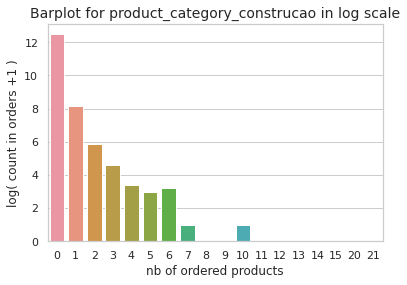

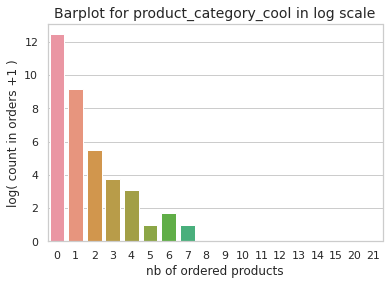

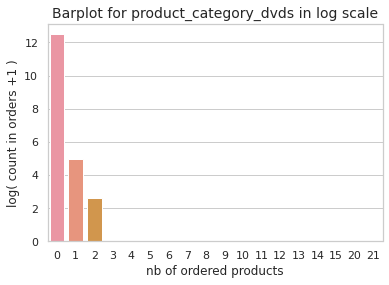

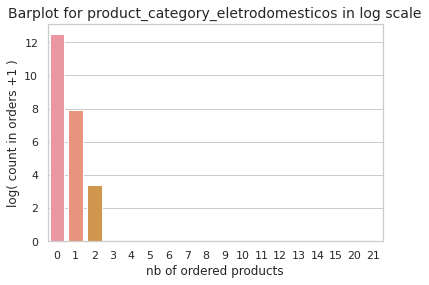

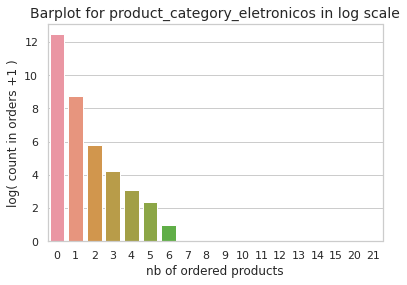

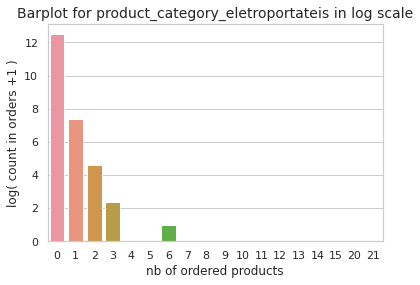

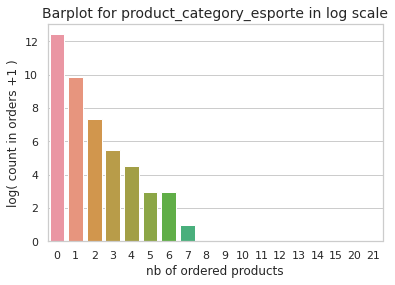

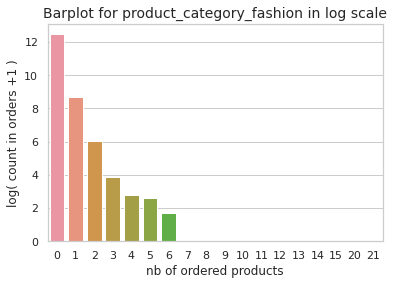

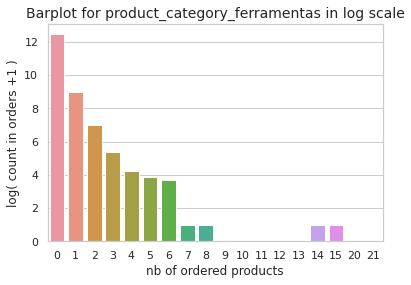

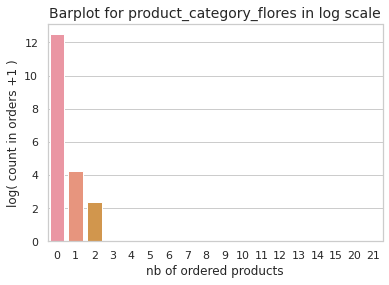

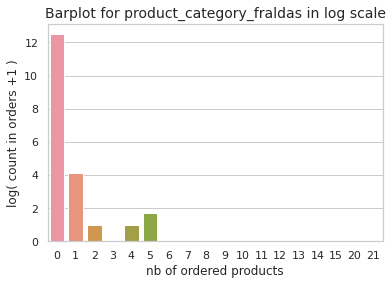

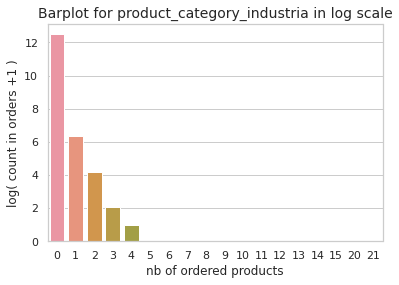

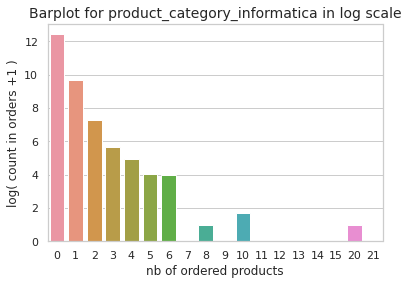

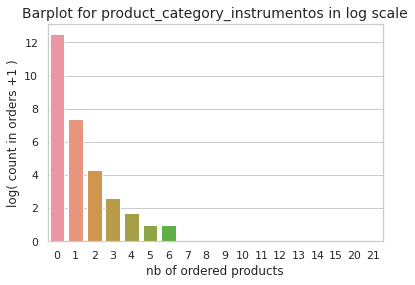

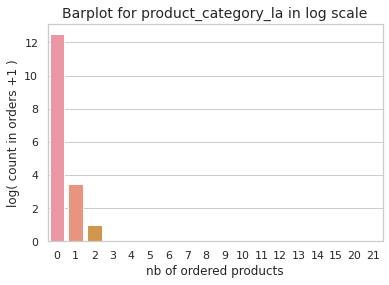

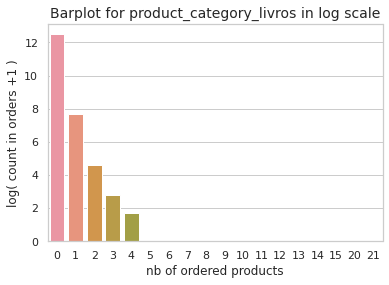

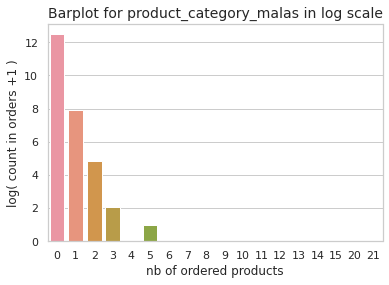

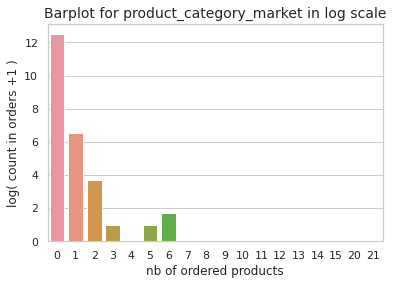

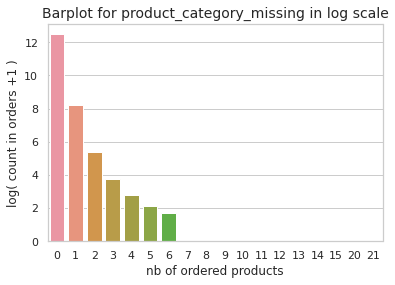

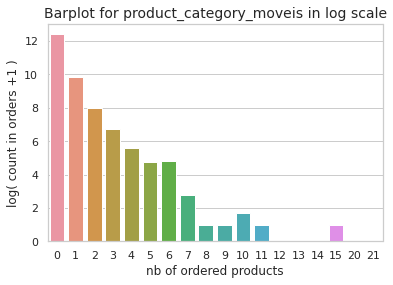

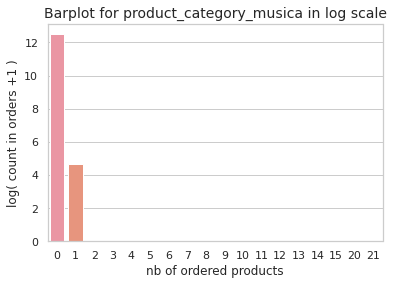

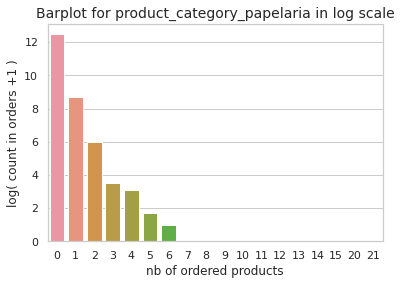

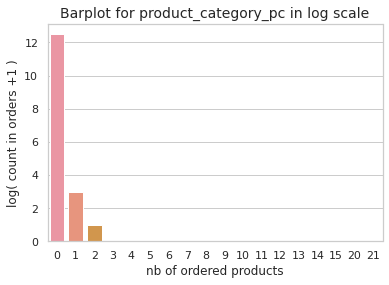

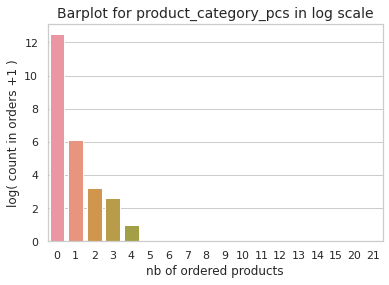

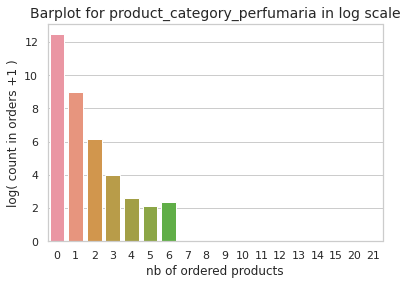

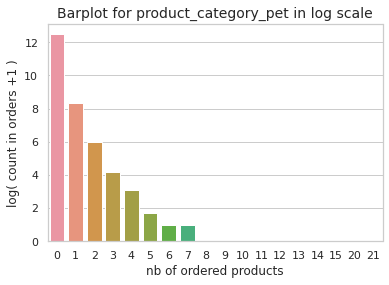

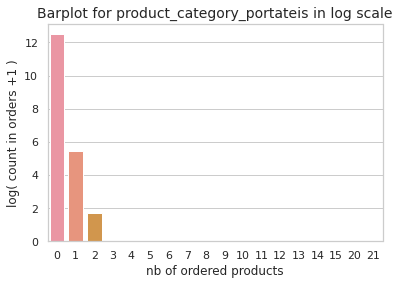

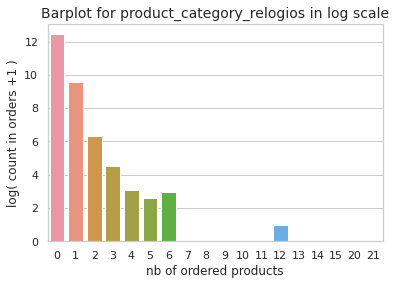

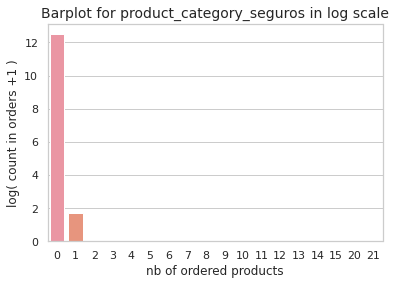

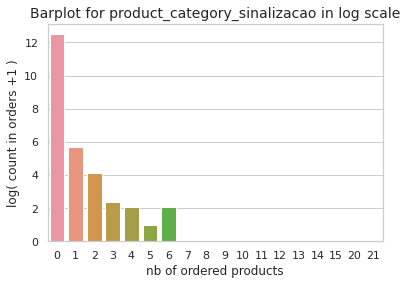

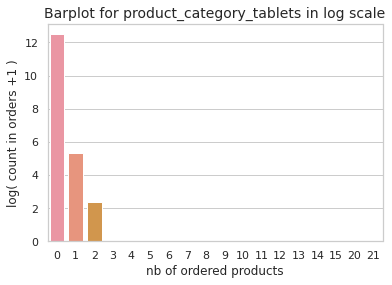

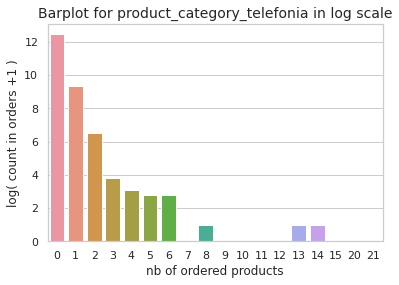

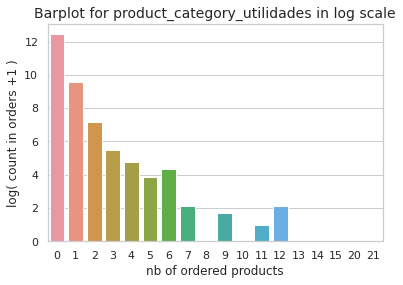

In [89]:
tmp3 = tmp2.loc[:,tmp2.columns[0]].value_counts()
for var in tmp2.columns[1:] : 
    tmp3 = pd.concat((tmp3,tmp2[var].value_counts()), axis = 1)
# tmp3 = tmp3.fillna(0)
# tmp3 = tmp3.drop(0, axis = 0)
for var in tmp3.columns : 
    sns.barplot(x = tmp3.index, 
                y = np.log(tmp3.loc[:,var].values)+1)
    plt.title("Barplot for "+ var+" in log scale",fontsize=14)
    plt.xlabel("nb of ordered products")
    plt.ylabel("log( count in orders +1 )")
    plt.show()

Cette classification des produits n'est clairement pas adaptée à ce jeu de données. Je vais faire un traitement "à la main" avec la traduction des catégories qui m'a été fournie : 

In [90]:
new_cat = product_category_name_translation.astype("category")
for idx in y.index :
    old_cat = y.loc[idx,"product_category_name"]
    new_cat.at[idx,"new_category_name"] = old_cat.split("_")[0]
rename_cat = new_cat[["product_category_name", "new_category_name"]]
rename_cat = rename_cat.set_index("product_category_name").to_dict()
rename_cat = rename_cat["new_category_name"]
rename_cat['la']="cuisine"
# y.replace(rename_cat)

In [91]:
# np.array(y["product_category_name_english"])
rename_categories_english = {
    "home_furnitures" : ['bed_bath_table','furniture_decor', 
                         'housewares','office_furniture',
                         'kitchen_dining_laundry_garden_furniture',
                         'home_confort','furniture_mattress_and_upholstery',
                         'furniture_living_room', 'furniture_bedroom',
                         'home_comfort_2',
                        ],
    "home_electronics":['small_appliances','air_conditioning',
                        'home_appliances','home_appliances_2',
                        'la_cuisine','small_appliances_home_oven_and_coffee',
                        "kitchen_portables_and_food_preparers"
                       ],
    "electronics":['computers_accessories','telephony',
                   'tablets_printing_image', 'fixed_telephony',
                   'consoles_games', 'audio','electronics',
                   'computers',
                  ],
    "multimedia" : ['books_general_interest','books_imported',
                    'cine_photo','music', 
                    'cds_dvds_musicals', 'dvds_blu_ray',
                   ], 
    "fashion" : ['fashion_bags_accessories','fashion_shoes',
                 'fashion_male_clothing','fashion_underwear_beach',
                 'fashion_sport', 'fashio_female_clothing',
                ],
    "children" : [ 'baby','toys',
                   'fashion_childrens_clothes'
                 ],
    "health" : ['health_beauty', 'perfumery',
                'diapers_and_hygiene'
               ],
    "food_drink" : ['food_drink','market_place',
                    'agro_industry_and_commerce','food',
                    'drinks'
                    ],
    "leisure" : ['auto','sports_leisure',
                 'watches_gifts',  'stationery',
                 'luggage_accessories', 'pet_shop',
                 'party_supplies','musical_instruments',
                 'arts_and_craftmanship',
                ],
    "decoration" : ['cool_stuff','art',
                    'christmas_supplies','flowers',
                   ],
    "DIY" : ['garden_tools','construction_tools_construction',
             'costruction_tools_garden','costruction_tools_tools', 
             'books_technical','home_construction',
             'construction_tools_lights','construction_tools_safety',
             'industry_commerce_and_business',
            ],
    "security" : ['signaling_and_security','security_and_services']
    }

rename_cat = product_category_name_translation.copy()
## manquait 2 variables dans la table de traduction :
rename_cat = rename_cat.append({"product_category_name":"portateis_cozinha_e_preparadores_de_alimentos",
                   "product_category_name_english" : "kitchen_portables_and_food_preparers"},
                   ignore_index=True)
rename_cat = rename_cat.append({"product_category_name": "pc_gamer",
                   "product_category_name_english" : "pc_gamer"},
                   ignore_index=True)
for new_cat, list_old_cat in rename_categories_english.items():
    bool_idx = rename_cat["product_category_name_english"].isin(list_old_cat)
    cat_idx = rename_cat.loc[bool_idx].index
    rename_cat.at[cat_idx, "new_cat_english"] = new_cat
dict_rename_cat = rename_cat[["product_category_name","new_cat_english"]]
dict_rename_cat = dict_rename_cat.set_index("product_category_name")
dict_rename_cat = dict_rename_cat.to_dict()["new_cat_english"]

In [92]:
y = products[["product_id","product_category_name"]]
# y = y.set_index("product_id")
y = y.replace(dict_rename_cat)
# y = y.fillna("missing")
y = y.astype("category")

if "product_category_name" in my_products.columns:
    my_products = my_products.drop(columns="product_category_name")
my_products = pd.merge(y,my_products, on="product_id",how="left")

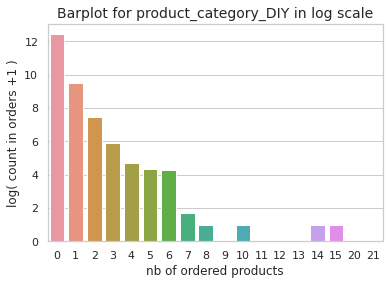

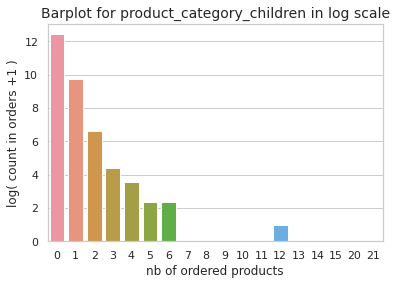

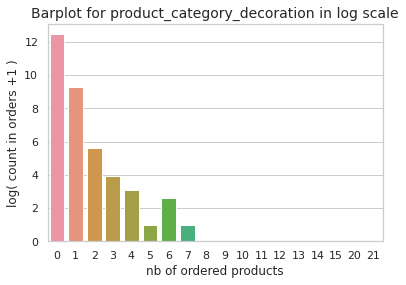

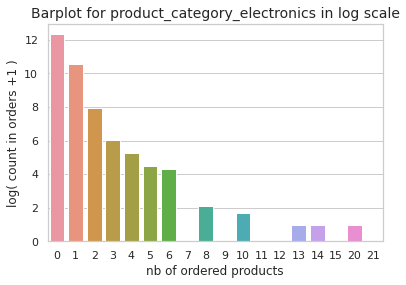

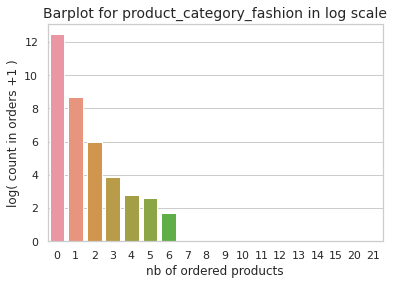

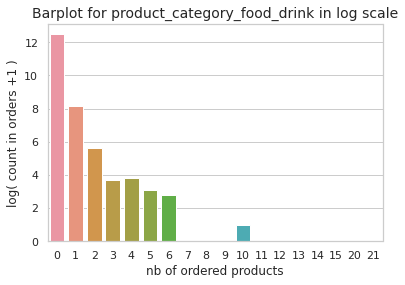

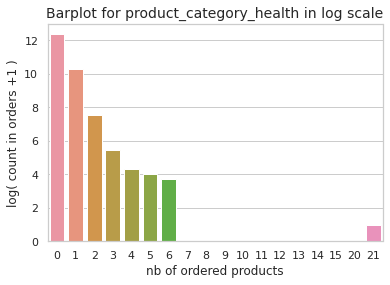

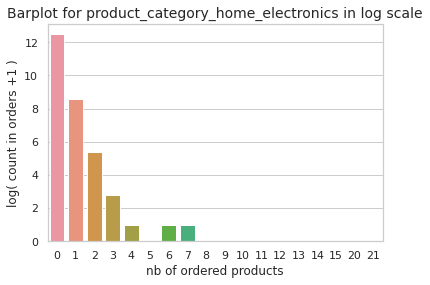

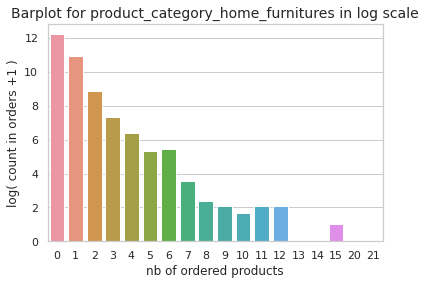

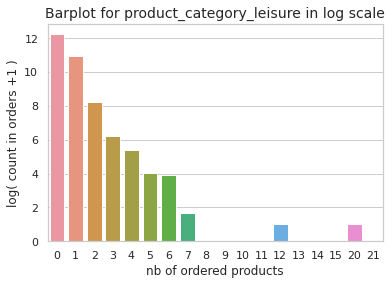

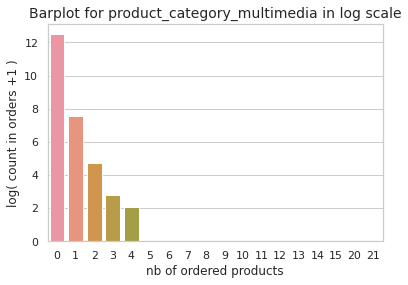

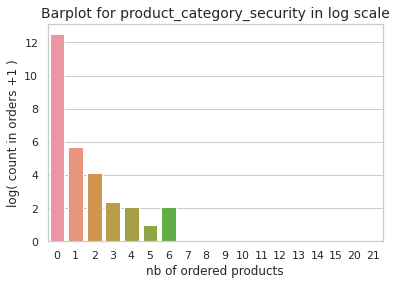

In [93]:
y2_dummies = pd.get_dummies(my_products["product_category_name"])
y2_dummies = y2_dummies.add_prefix("product_category_")
y2_dummies = y2_dummies.set_index(y["product_id"]).reset_index()
y2_dummies
## create a df with order, id, and the binary cat variables to be sum
# tmp = my_products.loc[:,my_products.dtypes == "category"].copy()
tmp = y2_dummies.set_index("product_id")
tmp = tmp.astype(int).reset_index()
tmp.at[:,"product_id"]=my_products.product_id.values
tmp = pd.merge(order_items[["order_id","product_id"]], tmp, 
               on="product_id", how="right")
tmp = tmp.drop(columns="product_id")

## gather on order and sum :
tmp2 = tmp.groupby("order_id").sum()
tmp2 = tmp2.astype("category")

tmp3 = tmp2.loc[:,tmp2.columns[0]].value_counts()
for var in tmp2.columns[1:] : 
    tmp3 = pd.concat((tmp3,tmp2[var].value_counts()), axis = 1)
# tmp3 = tmp3.fillna(0)
# tmp3 = tmp3.drop(0, axis = 0)
for var in tmp3.columns : 
    sns.barplot(x = tmp3.index, 
                y = np.log(tmp3.loc[:,var].values)+1)
    plt.title("Barplot for "+ var+" in log scale",fontsize=14)
    plt.xlabel("nb of ordered products")
    plt.ylabel("log( count in orders +1 )")
    plt.show()

Et pour la forme, je relance l'ANOVA lasso sur ce plus petit nombre de catégories : 

for axis1 in log space :


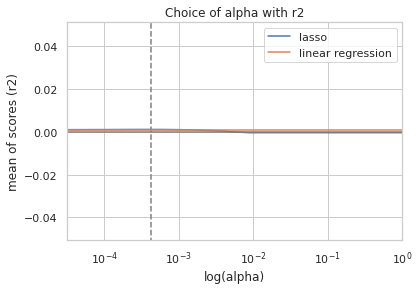

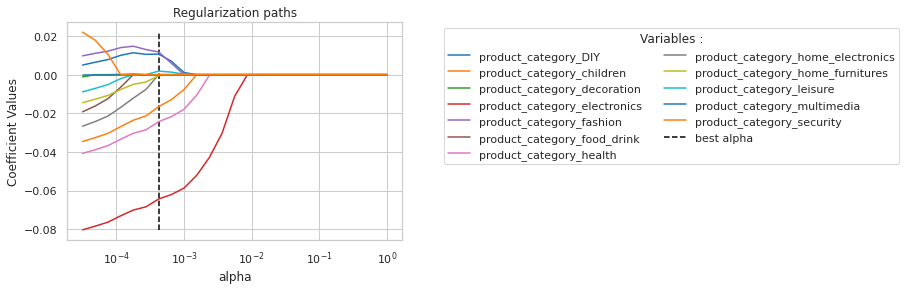

for axis2 in log space :


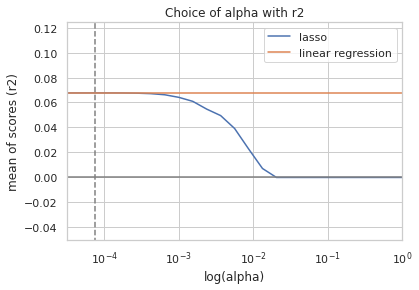

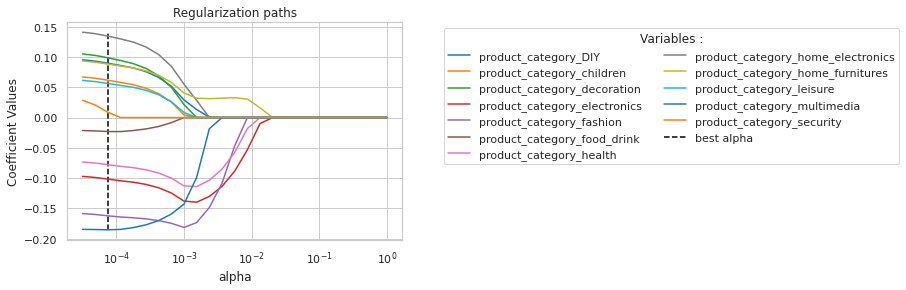

for axis3 in log space :


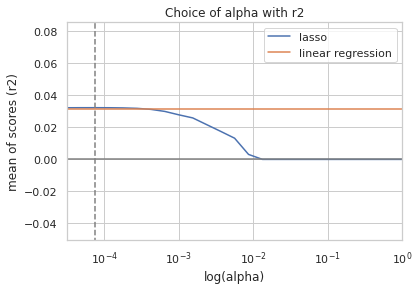

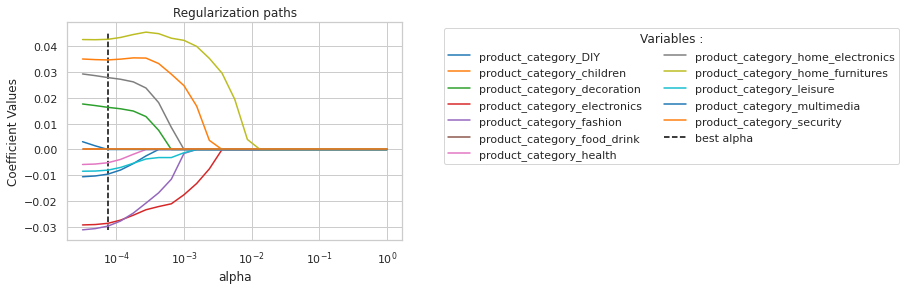

for axis4 in log space :


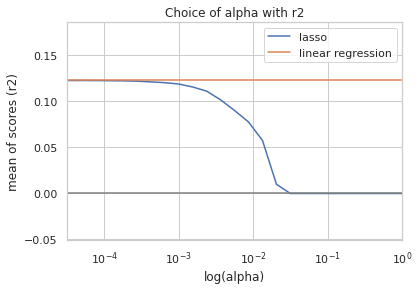

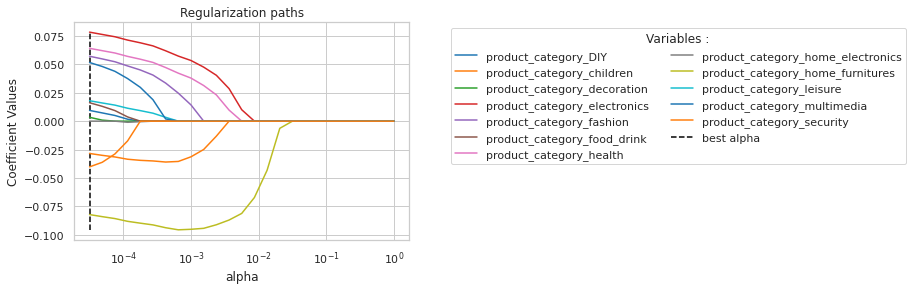

In [94]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
               "lasso" : linear_model.Lasso(),
              }

dict_param_grid["lasso"] = np.logspace(-4.5, 0, 25)

for var in ["axis"+str(k+1) for k in range(4)]:
#     var = "axis1"
    X_ = y2_dummies.set_index("product_id")
    y_ = X_proj[var]
    cte = max(-min(y_[y_<0]),0)
    y_ = np.log(y_ + cte + 1)
    print("for", var, "in log space :")
    res = compare_regressions(X_, y_, {"lasso" : linear_model.Lasso(max_iter=10000)}, 
                              dict_param_grid, score_name="r2", fig_name=None)
    plt.show()
    ## regul paths :
    model_name = "lasso"
    legend_kwargs = {"loc" : "upper right","bbox_to_anchor":(2.5, 1), "ncol":2}
    plot_regul_paths(alpha_values = dict_param_grid[model_name], lm_model = dict_models[model_name], 
                     X_ = X_, y_ = y_, best_alpha=res.loc[model_name, "best_alpha"],
                     var_names = X_.columns, legend_kwargs=legend_kwargs)
    plt.show()


La régression est toujours aussi mauvaise (voir pire). Il n'y a vraiment pas de structures dans dans ces catégories de produit.

# 4. Retour à l'échelle des commandes : 
Si je veux intégrer cette classification des produits dans les commandes, je vais devoir utiliser la table qui fait le lien commande-produit, c'est à dire "order_items", ou la table déjà extraite, link_order_product.

In [95]:
product_cat_dummies = pd.get_dummies(my_products["product_category_name"])
product_cat_dummies = product_cat_dummies.add_prefix("product_category_")
product_cat_dummies = product_cat_dummies.set_index(products["product_id"]).reset_index()

order_cat = pd.merge(link_order_product,product_cat_dummies, on="product_id", how="left")
order_cat = order_cat.drop(columns="product_id")
print(order_cat.shape)
order_cat = order_cat.groupby("order_id").sum()
order_cat.sum(axis=0)

(112650, 13)


product_category_DIY                  7254
product_category_children             7190
product_category_decoration           4191
product_category_electronics         17190
product_category_fashion              2634
product_category_food_drink           1690
product_category_health              13128
product_category_home_electronics     2090
product_category_home_furnitures     29499
product_category_leisure             25170
product_category_multimedia            801
product_category_security              201
dtype: int64

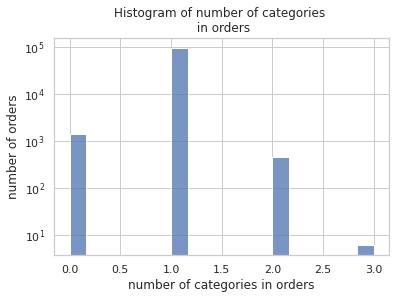

In [96]:
order_diff_cat = order_cat.copy()
order_diff_cat[order_cat>1] = 1
sns.histplot(order_diff_cat.sum(axis=1))
plt.yscale("log")
plt.title("Histogram of number of categories \n in orders")
plt.xlabel("number of categories in orders")
plt.ylabel("number of orders")
plt.savefig(res_path+"figures/"+"order_nb_cat_products.jpg")

In [97]:
## chexk why 0 : 
no_cat_order = order_cat[order_cat.sum(axis=1)==0].index
my_orders[my_orders["order_id"].isin(no_cat_order)]
no_cat_products = link_order_product[link_order_product.order_id.isin(no_cat_order)]["product_id"]
my_products[my_products["product_id"].isin(no_cat_products)]["product_category_name"]

128      NaN
154      NaN
197      NaN
244      NaN
294      NaN
        ... 
32476    NaN
32487    NaN
32616    NaN
32772    NaN
32852    NaN
Name: product_category_name, Length: 574, dtype: category
Categories (12, object): ['DIY', 'children', 'decoration', 'electronics', ..., 'home_furnitures', 'leisure', 'multimedia', 'security']

Ok, c'est normal que certaine commande ne fasse appel à aucune catégorie, comme certains produits ne sont pas tagués. J'ajoute cette variable de dispersion des commandes dans les catégories de produit à ma table d'étude "my_orders"

In [98]:
tmp = order_diff_cat.sum(axis=1)
tmp = tmp.reset_index().rename(columns={0:"count_prod_cat"})
my_orders = pd.merge(my_orders, tmp, on="order_id", how="left")

Et j'ajoute aussi le nombre maximal de produit par catégorie dans chaque commande :

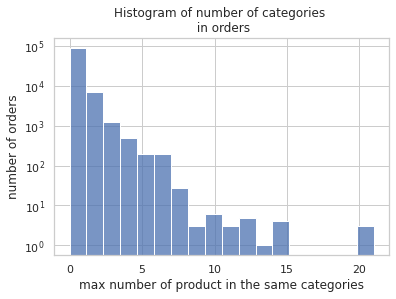

In [99]:
tmp = order_cat.max(axis=1)
sns.histplot(tmp)
plt.yscale("log")
plt.title("Histogram of number of categories \n in orders")
plt.xlabel("max number of product in the same categories")
plt.ylabel("number of orders")
plt.savefig(res_path+"figures/"+"order_nb_cat_products.jpg")

Et si j'enlevais le même produit commandé en plusieurs exemplaires : 

(102425, 14)


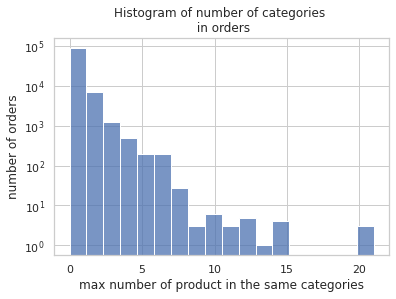

In [100]:
order_cat_no_duplc = pd.merge(link_order_product,product_cat_dummies, on="product_id", how="left")
order_cat_no_duplc = order_cat_no_duplc.drop_duplicates(subset=["order_id","product_id"])
print(order_cat_no_duplc.shape)
order_cat_no_duplc = order_cat_no_duplc.drop(columns="product_id")
order_cat_no_duplc = order_cat.groupby("order_id").sum()
order_cat_no_duplc.sum(axis=0)

tmp = order_cat_no_duplc.max(axis=1)
tmp = tmp.rename("count_max_product_in_cat")
sns.histplot(tmp)
plt.yscale("log")
plt.title("Histogram of number of categories \n in orders")
plt.xlabel("max number of product in the same categories")
plt.ylabel("number of orders")
plt.savefig(res_path+"figures/"+"order_nb_cat_products.jpg")

Il est intéressant de voir que ce ne sont pas des produits identiques commandés plusieurs fois qui influent la forme de cet histogramme. Je vais ajouter également cette variable à ma table "orders".

In [101]:
my_order = pd.merge(my_orders,tmp, on="order_id", how="left")

Je supprime les variable corrélées, comme la colonne count_change_score qui est corrélée à count_review :

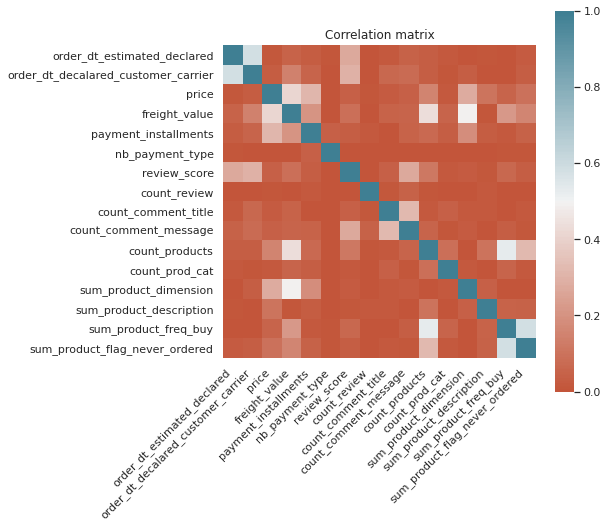

In [162]:
if "count_change_scores" in my_orders.columns :
    my_orders = my_orders.drop(columns="count_change_scores")
if "sum_product_flag_ordered_alone" in my_orders.columns :
    my_orders = my_orders.drop(columns="sum_product_flag_ordered_alone")
if "sum_product_freight_value" in my_orders.columns :
    my_orders = my_orders.drop(columns="sum_product_freight_value")
if "sum_product_price" in my_orders.columns :
    my_orders = my_orders.drop(columns="sum_product_price")
plot_corr_heatmap(abs(my_orders.corr()))

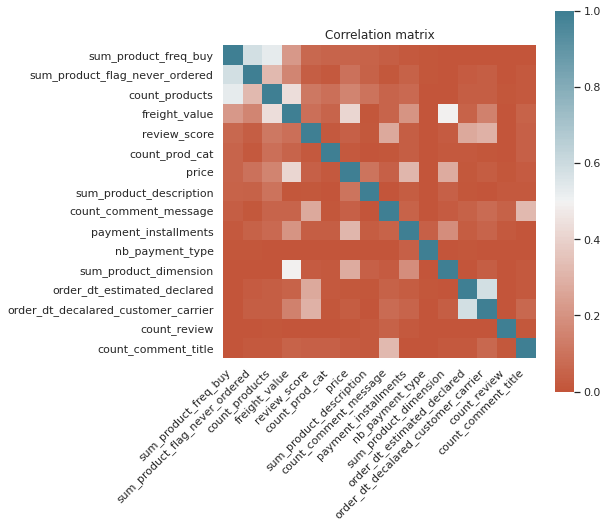

In [163]:
sorted_corr = abs(my_orders.corr()).sort_values(by="sum_product_freq_buy", ascending = False)
sorted_corr = sorted_corr.sort_values(by="sum_product_freq_buy", axis = 1, ascending = False)
plot_corr_heatmap(sorted_corr)
